In [1]:
# Imports
!pip install sympy --quiet
from scipy.integrate import solve_bvp
import numpy as np
import scipy.optimize as opt       # import root-finding algorithm
import sympy as sp                 # Python toolbox for symbolic maths
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Toolbox for rendring 3D figures
from mpl_toolkits import mplot3d   # Toolbox for rendring 3D figures
# @title Figure Settings
import ipywidgets as widgets  # interactive display
from ipywidgets import interact
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

fig_w, fig_h = 12, 4.5
my_fontsize = 16
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

In [2]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]

In [3]:
def PlotSingleSimSingleProtein(x,y1,y2,lab1,lab2,xlab,ylab,title_string,file_name,width=10,height=8,fsize=16,save_it = 1):
    print(width,height)
    fig, axes = plt.subplots(1, 2,figsize=(width, height))
    ax = axes.ravel()
#     plt.rc('font', **{'family':'serif','serif':['Palatino']})
    plt.rc('text', usetex=False)
    ax[0].plot(x,y1,label=lab1)
    ax[0].set_xlabel(xlab,fontsize=fsize)
    ax[0].set_ylabel(ylab,fontsize=fsize)
    plt.title(title_string,fontsize=fsize)
    ax[1].plot(x,y2,label=lab2)
    ax[1].set_xlabel(xlab,fontsize=fsize)
    ax[1].set_ylabel(ylab,fontsize=fsize)
    plt.title(title_string,fontsize=fsize)
    plt.legend(prop={'size': fsize})
    # plt.show()
    folder = "."
    if save_it == 1:
        plt.savefig("%s/%s.%s"%(folder,file_name,"png"),dpi=150)
        plt.savefig("%s/%s.%s"%(folder,file_name,"eps"),dpi=150)
        print("saved figures to: {%s/%s}" %(folder, file_name))
    else:
        print("Plots not saved")
    plt.show()
    

In [4]:
def PlotSingleSimTwoProtein(x,ps,pc,p_spine,lab_ps,lab_pc,lab_p_spine,xlab,ylab,title_string,file_name,width=10,height=8,fsize=16,save_it = 1):
    fig, axes = plt.subplots(1, 2,figsize=(width, height))
    ax = axes.ravel()
#     plt.rc('font', **{'family':'serif','serif':['Palatino']})
#     plt.rc('text', usetex=True)
    ax[0].plot(x,ps,label=lab_ps,color=color_list[0])
    ax[0].plot(x,pc,label=lab_pc,color=color_list[1])
    ax[0].set_xlabel(xlab,fontsize=fsize)
    ax[0].set_ylabel(ylab,fontsize=fsize)
    plt.title(title_string,fontsize=fsize)
    ax[0].legend(prop={'size': fsize})
    ax[1].plot(x,p_spine,label=lab_p_spine,color=color_list[2])
    ax[1].set_xlabel(xlab,fontsize=fsize)
    ax[1].set_ylabel(ylab,fontsize=fsize)
    plt.title(title_string,fontsize=fsize)
#     plt.title(title_string,fontsize=fsize)
    ax[1].legend(prop={'size': fsize})
    # plt.show()
    folder = "."
    if save_it == 1:
        plt.savefig("%s/%s.%s"%(folder,file_name,"png"),dpi=150)
        plt.savefig("%s/%s.%s"%(folder,file_name,"eps"),dpi=150)
        print("saved figures to: {%s/%s}" %(folder, file_name))
    else:
        print("Plots not saved")
    plt.show()
    

## 1. Two protein with one-rate of synaptic uptake

## $ \frac{\partial P_c}{\partial t} = D_c \frac{\partial^2 P_c}{\partial x^2} - \frac{\partial (V_p(x)*P_c)}{\partial x} - \lambda_c P_c - \beta P_c + \alpha P_s $

## $ \frac{\partial P_s}{\partial t} = D_s \frac{\partial^2 P_s}{\partial x^2} - \lambda_s P_s -\alpha P_s + \beta P_s -\eta_s P_s $

## $ \frac{\partial P_{spine}}{\partial t} = \eta_s P_s $

In [5]:
L = 221     #length of the dendrite

In [ ]:
class DendriteWithSpines():
    def __init__(self,D_s,D_c,V_p,half_life_surf,half_life_int,alpha,beta,Jsin,Jcin,eta_s):
        self.D_s = D_s   # in uM^2/s
        self.D_c = D_c   # in uM^2/s
        self.V_p = V_p    # in uM/s
        self.half_life_surf = half_life_surf # in days
        self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        self.half_life_int = half_life_int # in days
        self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        self.alpha = alpha;
        self.beta = beta;
        self.Jsin = Jsin;
        self.Jcin = Jcin;
        self.eta_s = eta_s;
#         self.eta_c = eta_c;
        
    def updateModelParams(self,D_s = None,D_c = None,V_p = None,half_life_surf = None,half_life_int = None\
                          ,alpha = None,beta = None,Jsin = None,Jcin = None,eta_s = None):
        if D_s:
            self.D_s = D_s   # in uM^2/s
        if D_c:
            self.D_c = D_c   # in uM^2/s
        if V_p:
            self.V_p = V_p    # in uM/s
        if half_life_surf:
            self.half_life_surf = half_life_surf # in days
            self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        if half_life_int:
            self.half_life_int = half_life_int # in days
            self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        if alpha:
            self.alpha = alpha;
        if beta:
            self.beta = beta;
        if Jsin:
            self.Jsin = Jsin;
        if Jcin:
            self.Jcin = Jcin;
        if eta_s:
            self.eta_s = eta_s;

    
    def fun(self,x,y):
        ps,dps,pc,dpc = y
        return [dps,\
                ((self.alpha+self.eta_s)/self.D_s)*ps - (self.beta/self.D_s)*pc,\
                    dpc,\
                        ((self.beta+self.Lamda_pc)/self.D_c - self.V_p/(self.D_c*L))*pc + (self.V_p*(1-x/L)/self.D_c)*dpc - (self.alpha/self.D_c)*ps]
        
    def bc(self,ya,yb):
        return np.array([self.D_s*ya[1] + self.Jsin, self.D_s*yb[1], self.D_c*ya[3] - self.V_p*ya[2] + self.Jcin, self.D_c*yb[3]])
    
    def solveModel(self):
        delta_x = 0.0114; #step size for the numerical simulation
        # sim_id="001";
        # print(len(x_line))
        # solving model
        # D_p * p'' - (V_p(x)*p)' - Lamda_p*p = 0
        x=np.arange(0,L,delta_x)
        print(x)
        # params=np.array([L]);
        y = np.zeros((4,x.size))
        soln = solve_bvp(self.fun, self.bc, x, y,max_nodes=1e+9,verbose=2)
#         print(len(soln))
        ps_dist = soln.sol(x)[0]
        pc_dist = soln.sol(x)[2]
        # norm_ps_dist = ps_dist/ps_dist[0]
        # norm_pc_dist = pc_dist/ps_dist[0]
        # print(len(ps_dist))
        # plt.plot(x,ps_dist,label='P_s')
        # plt.plot(x,pc_dist,label='P_c')
        # plt.show()
        self.IntegralBC(delta_x,ps_dist, pc_dist)
        return x,ps_dist,pc_dist
    def IntegralBC(self,delta_x,ps_dist,pc_dist):
        protein_loss = -self.Jcin + (self.Lamda_pc*np.sum(pc_dist) + np.sum(self.eta_s*ps_dist))*delta_x
        print("protein lost/found  in the void = ",protein_loss)

In [ ]:
def RunSim(v_p=0.1,Jin=4000,alpha=0.1,beta=0.2,eta_s=1/2.67):
    print("=========================================================================================")
    print(" v_p =%.5f \t|| Jin = %2d \t|| alpha =%0.2f \t|| beta =%0.2f \t|| eta_{s0} = %.2e \n"%(v_p,Jin,alpha,beta,eta_s),end="")
    print("=========================================================================================")
    
    sim_id = "001";
    SP_model1 = DendriteWithSpines(0.45,0.05,v_p,float('inf'),20,alpha,beta,0.0,Jin,eta_s);
    x,ps_dist,pc_dist = SP_model1.solveModel()
    title_string = "test title"
    title_string = (r"Steady-state spatial distribution"+" \n parameters:\
       "+r" $D_s = %.2f, \lambda_s = %.2f,  \alpha = %.2f, \eta_s$ = %.1e "+" \n"+ \
        r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, \beta = %.2f$") \
        %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.alpha,SP_model1.eta_s,\
          SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.beta);
    lab_ps =  r'$P_s$'
    lab_pc =  r'$P_c$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'distribution of $P_s$ and $P_c$';
    folder= "Figures/TwoProtein/WithUptake/";
    file_name = folder+"TwoProtein_SingleSim_{0}".format(sim_id);
    # pwa = PlottingWidgetAMPA()
    # pwa.CreateFolderRecursive(folder)
    # PlotSingleSimTwoProtein(x, ps_dist,pc_dist,p_spine, lab_ps,lab_pc,lab_ps, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
    # title_string = (r"Steady-state spatial distribution in spines"+" \n parameters:\
    #    "+r" $D_s = %.2f, \lambda_s = %.2f,  \alpha = %.2f, \eta_s$ = %.1e "+" \n"+ \
    #     r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, \beta = %.2f$") \
    #     %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.alpha,SP_model1.eta_s,\
    #       SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.beta);
    lab_p_spine =  r'$p_{spine}$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'Normalized distribution';
    file_name = folder+"Spine_SingleSim_TwoProtein_dist_{0}".format(sim_id);
    print("\nratio of ps/pc = ",np.divide(ps_dist,pc_dist),"\nbeta/alpha =",beta/alpha)
    p_spine = SP_model1.eta_s*ps_dist ;
    print("SP_model1.eta_s = ",SP_model1.eta_s,"surface/spine = ",np.divide(ps_dist,p_spine))
    
    PlotSingleSimTwoProtein(x, ps_dist/ps_dist[0],pc_dist/ps_dist[0],p_spine/p_spine[0], lab_ps,lab_pc,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
    y_label= r'Protein distribution';
    PlotSingleSimTwoProtein(x, ps_dist,pc_dist,p_spine, lab_ps,lab_pc,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
#     print(np.sum(ps_dist)/np.sum(pc_dist),"\n",beta/alpha)
    # PlotSingleSimSingleProtein(x,np.zeros((np.shape(x))),p_spine,lab_ps,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)

_ = widgets.interact(RunSim,v = (0.1,1,0.1), Jin = (4000,40000,10000), alpha = (0.1,1,0.1),beta = (0.1,1,0.1),eta_s = (0, 1.5, .05))

## 2. Two protein with capped synaptic uptake and variable velocity

## $ \frac{\partial P_c}{\partial t} = D_c \frac{\partial^2 P_c}{\partial x^2} - \frac{\partial (V_p(x)*P_c)}{\partial x} - \lambda_c P_c - \beta P_c + \alpha P_s $

## $ \frac{\partial P_s}{\partial t} = D_s \frac{\partial^2 P_s}{\partial x^2} - \lambda_s P_s -\alpha P_s + \beta P_s -\eta_{smax} tanh(\eta_{s0} P_s) $

## $ \frac{\partial P_{spine}}{\partial t} = \eta_{smax} tanh(\eta_{s0} P_s) $

In [ ]:
class DendriteWithCappedUptakeSpines():
    def __init__(self,D_s,D_c,V_p,half_life_surf,half_life_int,alpha,beta,Jsin,Jcin,eta_s_max,eta_s_zero):
        self.D_s = D_s   # in uM^2/s
        self.D_c = D_c   # in uM^2/s
        self.V_p = V_p    # in uM/s
        self.half_life_surf = half_life_surf # in days
        self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        self.half_life_int = half_life_int # in days
        self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        self.alpha = alpha;
        self.beta = beta;
        self.Jsin = Jsin;
        self.Jcin = Jcin;
        self.eta_s_max = eta_s_max;
        self.eta_s_zero = eta_s_zero;
        
    def updateModelParams(self,D_s = None,D_c = None,V_p = None,half_life_surf = None,half_life_int = None\
                          ,alpha = None,beta = None,Jsin = None,Jcin = None,eta_s = None):
        if D_s:
            self.D_s = D_s   # in uM^2/s
        if D_c:
            self.D_c = D_c   # in uM^2/s
        if V_p:
            self.V_p = V_p    # in uM/s
        if half_life_surf:
            self.half_life_surf = half_life_surf # in days
            self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        if half_life_int:
            self.half_life_int = half_life_int # in days
            self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        if alpha:
            self.alpha = alpha;
        if beta:
            self.beta = beta;
        if Jsin:
            self.Jsin = Jsin;
        if Jcin:
            self.Jcin = Jcin;
        if eta_s_max:
            self.eta_s_max = eta_s_max;
#         if eta_c_max:
#             self.eta_c_max = eta_c_max;
        if eta_s_zero:
            self.eta_s_zero = eta_s_zero;
#         if eta_c_zero:
#             self.eta_c_zero = eta_c_zero;
    
    def fun(self,x,y):
        ps,dps,pc,dpc = y
        return [dps,\
                ((self.alpha+self.Lamda_ps)/self.D_s)*ps + self.eta_s_max*np.tanh(self.eta_s_zero*ps)/self.D_s- (self.beta/self.D_s)*pc, dpc,\
                ((self.beta+self.Lamda_pc)/self.D_c - self.V_p/(self.D_c*L))*pc + (self.V_p*(1-x/L)/self.D_c)*dpc - (self.alpha/self.D_c)*ps]
                             
        
    def bc(self,ya,yb):
        return np.array([self.D_s*ya[1] + self.Jsin, self.D_s*yb[1], self.D_c*ya[3] - self.V_p*ya[2] + self.Jcin, self.D_c*yb[3]])

    def solveModel(self):
        delta_x = 0.0114; #step size for the numerical simulation
        # sim_id="001";
        # print(len(x_line))
        # solving model
        # D_p * p'' - (V_p(x)*p)' - Lamda_p*p = 0
        x=np.arange(0,L,delta_x)
#         print(x)
        params=np.array([L]);
        y = np.zeros((4,x.size))
        soln = solve_bvp(self.fun, self.bc, x, y,max_nodes=1e+9,verbose=2)
#         print(len(soln))
        ps_dist = soln.sol(x)[0]
        pc_dist = soln.sol(x)[2]
        self.IntegralBC(delta_x,ps_dist,pc_dist)
        return x, ps_dist, pc_dist
    
    def IntegralBC(self,delta_x,ps_dist,pc_dist):
        protein_loss = -self.Jcin + (self.Lamda_pc*np.sum(pc_dist) + np.sum(self.eta_s_max*np.tanh(self.eta_s_zero*ps_dist)))*delta_x
        print("protein lost/found  in the void = ",protein_loss)

In [ ]:
def RunSim2(v_p=0.1,Jcin=4000,alpha=0.1,beta = 0.2,eta_s0=1/2.67):
    print("=========================================================================================")
    print(" v_p =%.5f \t|| Jin = %2d \t|| alpha =%0.2f \t|| beta =%0.2f \t|| eta_s0 = %.2e \n"%(v_p,Jcin,alpha,beta,eta_s0),end="")
    print("=========================================================================================")
    SP_model1 = DendriteWithCappedUptakeSpines(0.45,0.05,v_p,float('inf'),20,alpha,beta,0.0,Jcin,60,eta_s0);
    sim_id = "002";
    x,ps_dist,pc_dist = SP_model1.solveModel()
#     title_string = (r"Steady-state spatial distribution"+" \n parameters:\
#        "+r" $D_s$ = %.2f, half-life-surf = %.2f, $Jsin= %.2f,  \alpha = %.2f, \eta_{smax} = %.1e ,\eta_{s0}$ = %.1e"+" \n"+ \
#         r"$D_c = {%.2f}, V_p = {%.1e}$, half-life-int = %.2f, $Jcin= %.2f, \beta = %.2f$") \
#     %( SP_model1.D_s, SP_model1.half_life_surf,SP_model1.Jsin,SP_model1.alpha,SP_model1.eta_s_max,SP_model1.eta_s_zero,\
#       SP_model1.D_c,SP_model1.V_p, SP_model1.half_life_int,SP_model1.Jcin,SP_model1.beta);
    lab_ps =  r'$P_s$'
    lab_pc =  r'$P_c$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'distribution of $P_s$ and $P_c$';
    folder= "Figures/TwoProtein/WithCappedUptake/{0}/".format(sim_id);
    file_name = folder+ "TwoProtein_SingleSim_withCappedSpinesUptake_{0}".format(sim_id);
#     pwa = PlottingWidgetAMPA()
#     pwa.CreateFolderRecursive(folder)
#     pwa.PlotSingleSimTwoProtein(x, ps_dist,pc_dist, lab_ps,lab_pc, x_label, y_label, title_string, file_name,fsize=14,save_it = 1)
    title_string = (r"Steady-state spatial distribution in Spines"+" \n parameters:\
       "+r" $D_s = %.2f,  \lambda_s = %.2f, Jsin= %.2f,  \alpha = %.2f, \eta_{smax} = %.1e ,\eta_{s0}$ = %.1e"+" \n"+ \
        r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_s = {%.1e}, Jcin= %.2f, \beta = %.2f$") \
    %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.Jsin,SP_model1.alpha,SP_model1.eta_s_max,SP_model1.eta_s_zero,\
      SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.Jcin,SP_model1.beta);
    lab_ps_spine =  r'$P_{spine}$'
    lab_pc_spine =  'Spine cytoplsmic AMPA-R'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'Normalized distribution';
    # folder= "Figures/OneProtein/WithCappedUptake/";
    file_name = folder+"Spine_SingleSim_TwoProtein_capped_uptake_dist_{0}".format(sim_id);
    ps_spine = SP_model1.eta_s_max*np.tanh(SP_model1.eta_s_zero*ps_dist) 
    print("ratio of ps/pc = ",np.sum(ps_dist)/np.sum(pc_dist),"\n beta/alpha =",beta/alpha)
#     print("relative pool size = ",ps_dist/)
#     pc_spine = SP_model1.eta_c_max*np.tanh(SP_model1.eta_c_zero*pc_dist);
    PlotSingleSimTwoProtein(x,ps_dist/ps_dist[0],pc_dist/ps_dist[0], ps_spine/ps_spine[0], lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)
    y_label= r'Distribution';
    PlotSingleSimTwoProtein(x,ps_dist,pc_dist, ps_spine, lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)


_ = widgets.interact(RunSim2,v_p = (0.1,1,0.1), Jcin = (4000,20000,1000), alpha = (0.1,1,0.1),beta = (0.1,1,0.1),eta_s0 = (0, 1.5, .05))

## 3. Two protein with capped synaptic uptake and constant velocity

## $ \frac{\partial P_c}{\partial t} = D_c \frac{\partial^2 P_c}{\partial x^2} - V_p\frac{\partial P_c}{\partial x} - \lambda_c P_c - \beta P_c + \alpha P_s $

## $ \frac{\partial P_s}{\partial t} = D_s \frac{\partial^2 P_s}{\partial x^2} - \lambda_s P_s -\alpha P_s + \beta P_s -\eta_{smax} tanh(\eta_{s0} P_s) $

## $ \frac{\partial P_{spine}}{\partial t} = \eta_{smax} tanh(\eta_{s0} P_s) $

In [ ]:
class DendriteWithCappedUptakeSpinesConstantV():
    def __init__(self,D_s,D_c,V_p,half_life_surf,half_life_int,alpha,beta,Jsin,Jcin,eta_s_max,eta_s_zero):
        self.D_s = D_s   # in uM^2/s
        self.D_c = D_c   # in uM^2/s
        self.V_p = V_p    # in uM/s
        self.half_life_surf = half_life_surf # in days
        self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        self.half_life_int = half_life_int # in days
        self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        self.alpha = alpha;
        self.beta = beta;
        self.Jsin = Jsin;
        self.Jcin = Jcin;
        self.eta_s_max = eta_s_max;
        self.eta_s_zero = eta_s_zero;
        
    def updateModelParams(self,D_s = None,D_c = None,V_p = None,half_life_surf = None,half_life_int = None\
                          ,alpha = None,beta = None,Jsin = None,Jcin = None,eta_s = None):
        if D_s:
            self.D_s = D_s   # in uM^2/s
        if D_c:
            self.D_c = D_c   # in uM^2/s
        if V_p:
            self.V_p = V_p    # in uM/s
        if half_life_surf:
            self.half_life_surf = half_life_surf # in days
            self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        if half_life_int:
            self.half_life_int = half_life_int # in days
            self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        if alpha:
            self.alpha = alpha;
        if beta:
            self.beta = beta;
        if Jsin:
            self.Jsin = Jsin;
        if Jcin:
            self.Jcin = Jcin;
        if eta_s_max:
            self.eta_s_max = eta_s_max;
#         if eta_c_max:
#             self.eta_c_max = eta_c_max;
        if eta_s_zero:
            self.eta_s_zero = eta_s_zero;
#         if eta_c_zero:
#             self.eta_c_zero = eta_c_zero;
    
    def fun(self,x,y):
        ps,dps,pc,dpc = y
        return [dps,\
                ((self.alpha+self.Lamda_ps)/self.D_s)*ps + self.eta_s_max*np.tanh(self.eta_s_zero*ps)/self.D_s- (self.beta/self.D_s)*pc, dpc,\
                ((self.beta+self.Lamda_pc)/self.D_c)*pc + (self.V_p/self.D_c)*dpc - (self.alpha/self.D_c)*ps]
                             
        
    def bc(self,ya,yb):
        return np.array([self.D_s*ya[1] + self.Jsin, self.D_s*yb[1], self.D_c*ya[3] - self.V_p*ya[2] + self.Jcin, self.D_c*yb[3]- self.V_p*yb[2]])

    def solveModel(self):
        delta_x = 0.0114; #step size for the numerical simulation
        # sim_id="001";
        # print(len(x_line))
        # solving model
        # D_p * p'' - (V_p(x)*p)' - Lamda_p*p = 0
        x=np.arange(0,L,delta_x)
#         print(x)
        params=np.array([L]);
        y = np.zeros((4,x.size))
        soln = solve_bvp(self.fun, self.bc, x, y,max_nodes=1e+9,verbose=2)
#         print(len(soln))
        ps_dist = soln.sol(x)[0]
        pc_dist = soln.sol(x)[2]
        self.IntegralBC(delta_x,ps_dist,pc_dist)
        return x, ps_dist, pc_dist
    
    def IntegralBC(self,delta_x,ps_dist,pc_dist):
        protein_loss = -self.Jcin + (self.Lamda_pc*np.sum(pc_dist) + np.sum(self.eta_s_max*np.tanh(self.eta_s_zero*ps_dist)))*delta_x
        print("protein lost/found  in the void = ",protein_loss)

In [ ]:
def RunSim3(v_p=0.1,Jcin=4000,alpha=0.1,beta = 0.2,eta_s0=.001):
    print("=========================================================================================")
    print(" v_p =%.5f \t|| Jin = %2d \t|| alpha =%0.2f \t|| beta =%0.2f \t|| eta_s0 = %.2e \n"%(v_p,Jcin,alpha,beta,eta_s0),end="")
    print("=========================================================================================")
    SP_model1 = DendriteWithCappedUptakeSpinesConstantV(0.45,0.05,v_p,float('inf'),20,alpha,beta,0.0,Jcin,60,eta_s0);
    sim_id = "002";
    x,ps_dist,pc_dist = SP_model1.solveModel()
#     title_string = (r"Steady-state spatial distribution"+" \n parameters:\
#        "+r" $D_s$ = %.2f, half-life-surf = %.2f, $Jsin= %.2f,  \alpha = %.2f, \eta_{smax} = %.1e ,\eta_{s0}$ = %.1e"+" \n"+ \
#         r"$D_c = {%.2f}, V_p = {%.1e}$, half-life-int = %.2f, $Jcin= %.2f, \beta = %.2f$") \
#     %( SP_model1.D_s, SP_model1.half_life_surf,SP_model1.Jsin,SP_model1.alpha,SP_model1.eta_s_max,SP_model1.eta_s_zero,\
#       SP_model1.D_c,SP_model1.V_p, SP_model1.half_life_int,SP_model1.Jcin,SP_model1.beta);
    lab_ps =  r'$P_s$'
    lab_pc =  r'$P_c$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'distribution of $P_s$ and $P_c$';
    folder= "Figures/TwoProtein/WithCappedUptake/{0}/".format(sim_id);
    file_name = folder+ "TwoProtein_SingleSim_withCappedSpinesUptake_{0}".format(sim_id);
#     pwa = PlottingWidgetAMPA()
#     pwa.CreateFolderRecursive(folder)
#     pwa.PlotSingleSimTwoProtein(x, ps_dist,pc_dist, lab_ps,lab_pc, x_label, y_label, title_string, file_name,fsize=14,save_it = 1)
    title_string = (r"Steady-state spatial distribution in Spines"+" \n parameters:\
       "+r" $D_s = %.2f,  \lambda_s = %.2f, Jsin= %.2f,  \alpha = %.2f, \eta_{smax} = %.1e ,\eta_{s0}$ = %.1e"+" \n"+ \
        r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_s = {%.1e}, Jcin= %.2f, \beta = %.2f$") \
    %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.Jsin,SP_model1.alpha,SP_model1.eta_s_max,SP_model1.eta_s_zero,\
      SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.Jcin,SP_model1.beta);
    lab_ps_spine =  r'$P_{spine}$'
    lab_pc_spine =  'Spine cytoplsmic AMPA-R'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'Normalized distribution';
    # folder= "Figures/OneProtein/WithCappedUptake/";
    file_name = folder+"Spine_SingleSim_TwoProtein_capped_uptake_dist_constantV_{0}".format(sim_id);
    ps_spine = SP_model1.eta_s_max*np.tanh(SP_model1.eta_s_zero*ps_dist) 
    print("ratio of ps/pc = ",np.sum(ps_dist)/np.sum(pc_dist),"\n beta/alpha =",beta/alpha)
    print(ps_dist[:20],"\n",pc_dist[:20])
#     pc_spine = SP_model1.eta_c_max*np.tanh(SP_model1.eta_c_zero*pc_dist);
    PlotSingleSimTwoProtein(x,ps_dist/ps_dist[0],pc_dist/ps_dist[0], ps_spine/ps_spine[0], lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)
    y_label= r'Distribution';
    PlotSingleSimTwoProtein(x,ps_dist,pc_dist, ps_spine, lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)
    delta_x = 0.0114
    PlotSingleSimTwoProtein(x[1:int(160/delta_x)],ps_dist[1:int(160/delta_x)],pc_dist[1:int(160/delta_x)], ps_spine[1:int(160/delta_x)], lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)

_ = widgets.interact(RunSim3,v_p = (0.1,1,0.1), Jcin = (4000,13300,1000), alpha = (0.1,1,0.1),beta = (0.1,1,0.1),eta_s0 = (0, 0.0115, .001))

## 4. Two protein with synaptic uptake and constant velocity

## $ \frac{\partial P_c}{\partial t} = D_c \frac{\partial^2 P_c}{\partial x^2} - V_p\frac{\partial P_c}{\partial x} - \lambda_c P_c - \beta P_c + \alpha P_s $

## $ \frac{\partial P_s}{\partial t} = D_s \frac{\partial^2 P_s}{\partial x^2} - \lambda_s P_s -\alpha P_s + \beta P_s - \eta_{s} P_s $

## $ \frac{\partial P_{spine}}{\partial t} = \eta_{s} P_s $

In [ ]:
class DendriteWithSpinesConstantV():
    def __init__(self,D_s,D_c,V_p,half_life_surf,half_life_int,alpha,beta,Jsin,Jcin,eta_s):
        self.D_s = D_s   # in uM^2/s
        self.D_c = D_c   # in uM^2/s
        self.V_p = V_p    # in uM/s
        self.half_life_surf = half_life_surf # in days
        self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        self.half_life_int = half_life_int # in days
        self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        self.alpha = alpha;
        self.beta = beta;
        self.Jsin = Jsin;
        self.Jcin = Jcin;
        self.eta_s = eta_s;
#         self.eta_c = eta_c;
        
    def updateModelParams(self,D_s = None,D_c = None,V_p = None,half_life_surf = None,half_life_int = None\
                          ,alpha = None,beta = None,Jsin = None,Jcin = None,eta_s = None):
        if D_s:
            self.D_s = D_s   # in uM^2/s
        if D_c:
            self.D_c = D_c   # in uM^2/s
        if V_p:
            self.V_p = V_p    # in uM/s
        if half_life_surf:
            self.half_life_surf = half_life_surf # in days
            self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        if half_life_int:
            self.half_life_int = half_life_int # in days
            self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        if alpha:
            self.alpha = alpha;
        if beta:
            self.beta = beta;
        if Jsin:
            self.Jsin = Jsin;
        if Jcin:
            self.Jcin = Jcin;
        if eta_s:
            self.eta_s = eta_s;

    
    def fun(self,x,y):
        ps,dps,pc,dpc = y
        return [dps,\
                ((self.alpha+self.eta_s)/self.D_s)*ps - (self.beta/self.D_s)*pc,\
                    dpc,\
                        ((self.beta+self.Lamda_pc)/self.D_c )*pc + (self.V_p/self.D_c)*dpc - (self.alpha/self.D_c)*ps]
        
    def bc(self,ya,yb):
        return np.array([self.D_s*ya[1] + self.Jsin, self.D_s*yb[1], self.D_c*ya[3] - self.V_p*ya[2] + self.Jcin, self.D_c*yb[3]- self.V_p*yb[2]])
    
    def solveModel(self):
        delta_x = 0.0114; #step size for the numerical simulation
        # sim_id="001";
        # print(len(x_line))
        # solving model
        # D_p * p'' - (V_p(x)*p)' - Lamda_p*p = 0
        x=np.arange(0,L,delta_x)
        print(x)
        # params=np.array([L]);
        y = np.zeros((4,x.size))
        soln = solve_bvp(self.fun, self.bc, x, y,max_nodes=1e+9,verbose=2)
#         print(len(soln))
        ps_dist = soln.sol(x)[0]
        pc_dist = soln.sol(x)[2]
        # norm_ps_dist = ps_dist/ps_dist[0]
        # norm_pc_dist = pc_dist/ps_dist[0]
        # print(len(ps_dist))
        # plt.plot(x,ps_dist,label='P_s')
        # plt.plot(x,pc_dist,label='P_c')
        # plt.show()
        self.IntegralBC(delta_x,ps_dist, pc_dist)
        return x,ps_dist,pc_dist
    def IntegralBC(self,delta_x,ps_dist,pc_dist):
        protein_loss = -self.Jcin + (self.Lamda_pc*np.sum(pc_dist) + np.sum(self.eta_s*ps_dist))*delta_x
        print("protein lost/found  in the void = ",protein_loss)

In [ ]:
def RunSim4(v_p=0.1,Jin=4000,alpha=0.1,beta=0.2,eta_s=1/2.67):
    print("=========================================================================================")
    print(" v_p =%.5f \t|| Jin = %2d \t|| alpha =%0.2f \t|| beta =%0.2f \t|| eta_{s0} = %.2e \n"%(v_p,Jin,alpha,beta,eta_s),end="")
    print("=========================================================================================")
    
    sim_id = "001";
    SP_model1 = DendriteWithSpinesConstantV(0.45,0.05,v_p,float('inf'),20,alpha,beta,0.0,Jin,eta_s);
    x,ps_dist,pc_dist = SP_model1.solveModel()
    title_string = "test title"
    title_string = (r"Steady-state spatial distribution"+" \n parameters:\
       "+r" $D_s = %.2f, \lambda_s = %.2f,  \alpha = %.2f, \eta_s$ = %.1e "+" \n"+ \
        r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, \beta = %.2f$") \
        %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.alpha,SP_model1.eta_s,\
          SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.beta);
    lab_ps =  r'$P_s$'
    lab_pc =  r'$P_c$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'distribution of $P_s$ and $P_c$';
    folder= "Figures/TwoProtein/WithUptake/";
    file_name = folder+"TwoProtein_SingleSim_{0}".format(sim_id);
    # pwa = PlottingWidgetAMPA()
    # pwa.CreateFolderRecursive(folder)
    # PlotSingleSimTwoProtein(x, ps_dist,pc_dist,p_spine, lab_ps,lab_pc,lab_ps, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
    # title_string = (r"Steady-state spatial distribution in spines"+" \n parameters:\
    #    "+r" $D_s = %.2f, \lambda_s = %.2f,  \alpha = %.2f, \eta_s$ = %.1e "+" \n"+ \
    #     r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, \beta = %.2f$") \
    #     %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.alpha,SP_model1.eta_s,\
    #       SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.beta);
    lab_p_spine =  r'$p_{spine}$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'Normalized distribution';
    file_name = folder+"Spine_SingleSim_TwoProtein_dist_{0}".format(sim_id);
    print("\nratio of ps/pc = ",np.divide(ps_dist,pc_dist),"\nbeta/alpha =",beta/alpha)
    p_spine = SP_model1.eta_s*ps_dist ;
    print("SP_model1.eta_s = ",SP_model1.eta_s,"surface/spine = ",np.divide(ps_dist,p_spine))
    
    PlotSingleSimTwoProtein(x, ps_dist/ps_dist[0],pc_dist/ps_dist[0],p_spine/p_spine[0], lab_ps,lab_pc,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
    y_label= r'Protein distribution';
    PlotSingleSimTwoProtein(x, ps_dist,pc_dist,p_spine, lab_ps,lab_pc,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
#     print(np.sum(ps_dist)/np.sum(pc_dist),"\n",beta/alpha)
    # PlotSingleSimSingleProtein(x,np.zeros((np.shape(x))),p_spine,lab_ps,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)

_ = widgets.interact(RunSim4,v = (0.1,1,0.1), Jin = (4000,40000,10000), alpha = (0.1,1,0.1),beta = (0.1,1,0.1),eta_s = (0, 1.5, .05))

## 5. Two protein with two-rate of synaptic uptake

## $ \frac{\partial P_c}{\partial t} = D_c \frac{\partial^2 P_c}{\partial x^2} - V_p\frac{\partial P_c}{\partial x} - \lambda_c P_c - \beta P_c + \alpha P_s $

## $ \frac{\partial P_s}{\partial t} = D_s \frac{\partial^2 P_s}{\partial x^2} - \lambda_s P_s -\alpha P_s + \beta P_s -\eta_{s0} P_s (\eta_{smax}- P_{spine}) + \gamma P_{spine}$

## $ \frac{\partial P_{spine}}{\partial t} = \eta_{s0} P_s (\eta_{smax}- P_{spine}) - \gamma P_{spine}   $

In [6]:
class DendriteWithStochasticSpinesConstantV():
    def __init__(self,D_s,D_c,V_p,half_life_surf,half_life_int,alpha,beta,Jsin,Jcin,eta_s_max,eta_s_zero,gamma):
        self.D_s = D_s   # in uM^2/s
        self.D_c = D_c   # in uM^2/s
        self.V_p = V_p    # in uM/s
        self.half_life_surf = half_life_surf # in days
        self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        self.half_life_int = half_life_int # in days
        self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        self.alpha = alpha;
        self.beta = beta;
        self.Jsin = Jsin;
        self.Jcin = Jcin;
        self.eta_s_max = eta_s_max;
        self.eta_s_zero = eta_s_zero;
        self.gamma = gamma;
        
    def updateModelParams(self,D_s = None,D_c = None,V_p = None,half_life_surf = None,half_life_int = None\
                          ,alpha = None,beta = None,Jsin = None,Jcin = None,eta_s = None,gamma=None):
        if D_s:
            self.D_s = D_s   # in uM^2/s
        if D_c:
            self.D_c = D_c   # in uM^2/s
        if V_p:
            self.V_p = V_p    # in uM/s
        if half_life_surf:
            self.half_life_surf = half_life_surf # in days
            self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        if half_life_int:
            self.half_life_int = half_life_int # in days
            self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        if alpha:
            self.alpha = alpha;
        if beta:
            self.beta = beta;
        if Jsin:
            self.Jsin = Jsin;
        if Jcin:
            self.Jcin = Jcin;
        if eta_s_max:
            self.eta_s_max = eta_s_max;
#         if eta_c_max:
#             self.eta_c_max = eta_c_max;
        if eta_s_zero:
            self.eta_s_zero = eta_s_zero;
        if gamma:
            self.gamma = gamma;
    
    def fun(self,x,y):
        ps,dps,pc,dpc = y
        return [dps,\
                ((self.alpha+self.Lamda_ps)/self.D_s)*ps  - (self.beta/self.D_s)*pc, dpc,\
                ((self.beta+self.Lamda_pc)/self.D_c)*pc + (self.V_p/self.D_c)*dpc - (self.alpha/self.D_c)*ps\
               ]
                             
        
    def bc(self,ya,yb):
        return np.array([self.D_s*ya[1] + self.Jsin, self.D_s*yb[1], self.D_c*ya[3] - self.V_p*ya[2] + self.Jcin, self.D_c*yb[3]- self.V_p*yb[2]])

    def solveModel(self):
        delta_x = 0.0114; #step size for the numerical simulation
        # sim_id="001";
        # print(len(x_line))
        # solving model
        # D_p * p'' - (V_p(x)*p)' - Lamda_p*p = 0
        x=np.arange(0,L,delta_x)
#         print(x)
        params=np.array([L]);
        y = np.zeros((4,x.size))
        soln = solve_bvp(self.fun, self.bc, x, y,max_nodes=1e+9,verbose=2)
#         print(len(soln))
        ps_dist = soln.sol(x)[0]
        pc_dist = soln.sol(x)[2]
#         ps_spine = soln.sol(x)[4]
#         self.IntegralBC(delta_x,ps_dist,pc_dist)
        return x, ps_dist, pc_dist
    
    def IntegralBC(self,delta_x,ps_dist,pc_dist):
        protein_loss = -self.Jcin + (self.Lamda_pc*np.sum(pc_dist) + np.sum(self.eta_s_max*np.tanh(self.eta_s_zero*ps_dist)))*delta_x
        print("protein lost/found  in the void = ",protein_loss)

In [7]:
def RunSim5(v_p=0.0,Jcin=0.021,alpha=0.001,beta = 0.002,eta_s0=.001):
    print("=========================================================================================")
    print(" v_p =%.5f \t|| Jin = %2d \t|| alpha =%0.2f \t|| beta =%0.2f \t|| eta_s0 = %.2e \n"%(v_p,Jcin,alpha,beta,eta_s0),end="")
    print("=========================================================================================")
    SP_model1 = DendriteWithStochasticSpinesConstantV(0.45,0.5,v_p,float('inf'),4.35,alpha,beta,0.0,Jcin,60,eta_s0,1/43);
    sim_id = "002";
    x,ps_dist,pc_dist = SP_model1.solveModel()
#     title_string = (r"Steady-state spatial distribution"+" \n parameters:\
#        "+r" $D_s$ = %.2f, half-life-surf = %.2f, $Jsin= %.2f,  \alpha = %.2f, \eta_{smax} = %.1e ,\eta_{s0}$ = %.1e"+" \n"+ \
#         r"$D_c = {%.2f}, V_p = {%.1e}$, half-life-int = %.2f, $Jcin= %.2f, \beta = %.2f$") \
#     %( SP_model1.D_s, SP_model1.half_life_surf,SP_model1.Jsin,SP_model1.alpha,SP_model1.eta_s_max,SP_model1.eta_s_zero,\
#       SP_model1.D_c,SP_model1.V_p, SP_model1.half_life_int,SP_model1.Jcin,SP_model1.beta);
    lab_ps =  r'$P_s$'
    lab_pc =  r'$P_c$'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'distribution of $P_s$ and $P_c$';
    folder= "Figures/TwoProtein/WithCappedUptake/{0}/".format(sim_id);
    file_name = folder+ "TwoProtein_SingleSim_withCappedSpinesUptake_{0}".format(sim_id);
#     pwa = PlottingWidgetAMPA()
#     pwa.CreateFolderRecursive(folder)
#     pwa.PlotSingleSimTwoProtein(x, ps_dist,pc_dist, lab_ps,lab_pc, x_label, y_label, title_string, file_name,fsize=14,save_it = 1)
    title_string = (r"Steady-state spatial distribution in Spines"+" \n parameters:\
       "+r" $D_s = %.2f,  \lambda_s = %.2f, Jsin= %.2f,  \alpha = %.2f, \eta_{smax} = %.1e ,\eta_{s0}$ = %.1e"+" \n"+ \
        r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, Jcin= %.2f, \beta = %.2f$") \
    %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.Jsin,SP_model1.alpha,SP_model1.eta_s_max,SP_model1.eta_s_zero,\
      SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.Jcin,SP_model1.beta);
    lab_ps_spine =  r'$P_{spine}$'
    lab_pc_spine =  'Spine cytoplsmic AMPA-R'
    x_label = r'Dendritic distance in ($\mu$M)';
    y_label= r'Normalized distribution';
    # folder= "Figures/OneProtein/WithCappedUptake/";
    file_name = folder+"Spine_SingleSim_TwoProtein_capped_uptake_dist_constantV_{0}".format(sim_id);
#     ps_spine = SP_model1.eta_s_max*np.tanh(SP_model1.eta_s_zero*ps_dist) 
    print("ratio of ps/pc = ",np.sum(ps_dist)/np.sum(pc_dist),"\n beta/alpha =",beta/alpha)
    print(ps_dist[:20],"\n",pc_dist[:20])
    ps_spine = SP_model1.eta_s_max*(1/(1+SP_model1.gamma/(SP_model1.eta_s_zero*ps_dist)))
    PlotSingleSimTwoProtein(x,ps_dist/ps_dist[0],pc_dist/ps_dist[0], ps_spine/ps_spine[0], lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)
    y_label= r'Distribution';
    PlotSingleSimTwoProtein(x,ps_dist,pc_dist, ps_spine, lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)
    delta_x = 0.0114
#     PlotSingleSimTwoProtein(x[1:int(160/delta_x)],ps_dist[1:int(160/delta_x)],pc_dist[1:int(160/delta_x)], ps_spine[1:int(160/delta_x)], lab_ps,lab_pc, lab_ps_spine, x_label, y_label, title_string, file_name,fsize=14,save_it = 0)

_ = widgets.interact(RunSim5,v_p = (0,1e-3,1e-4), Jcin = (0.001,0.1,0.005), alpha = (0.001,1,0.1),beta = (0.001,1,0.1),eta_s0 = (0, 0.0115, .001))

interactive(children=(FloatSlider(value=0.0, description='v_p', max=0.001, step=0.0001), FloatSlider(value=0.0…

 v_p =0.10000 	|| Jin =  0 	|| alpha =0.01 	|| beta =0.02 	|| eta_s0 = 2.33e-02 
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.79e-08       1.96e-11         19386            0       
Solved in 1 iterations, number of nodes 19386. 
Maximum relative residual: 2.79e-08 
Maximum boundary residual: 1.96e-11
ratio of ps/pc =  1.999415475241235 
 beta/alpha = 2.0
[0.42167521 0.42167521 0.42167521 0.42167522 0.42167523 0.42167524
 0.42167526 0.42167528 0.4216753  0.42167532 0.42167535 0.42167538
 0.42167541 0.42167545 0.42167549 0.42167553 0.42167557 0.42167562
 0.42167567 0.42167572] 
 [0.21034331 0.21034409 0.21034487 0.21034565 0.21034643 0.21034721
 0.21034799 0.21034877 0.21034955 0.21035032 0.2103511  0.21035188
 0.21035265 0.21035343 0.2103542  0.21035497 0.21035574 0.21035652
 0.21035729 0.21035806]
Plots not saved


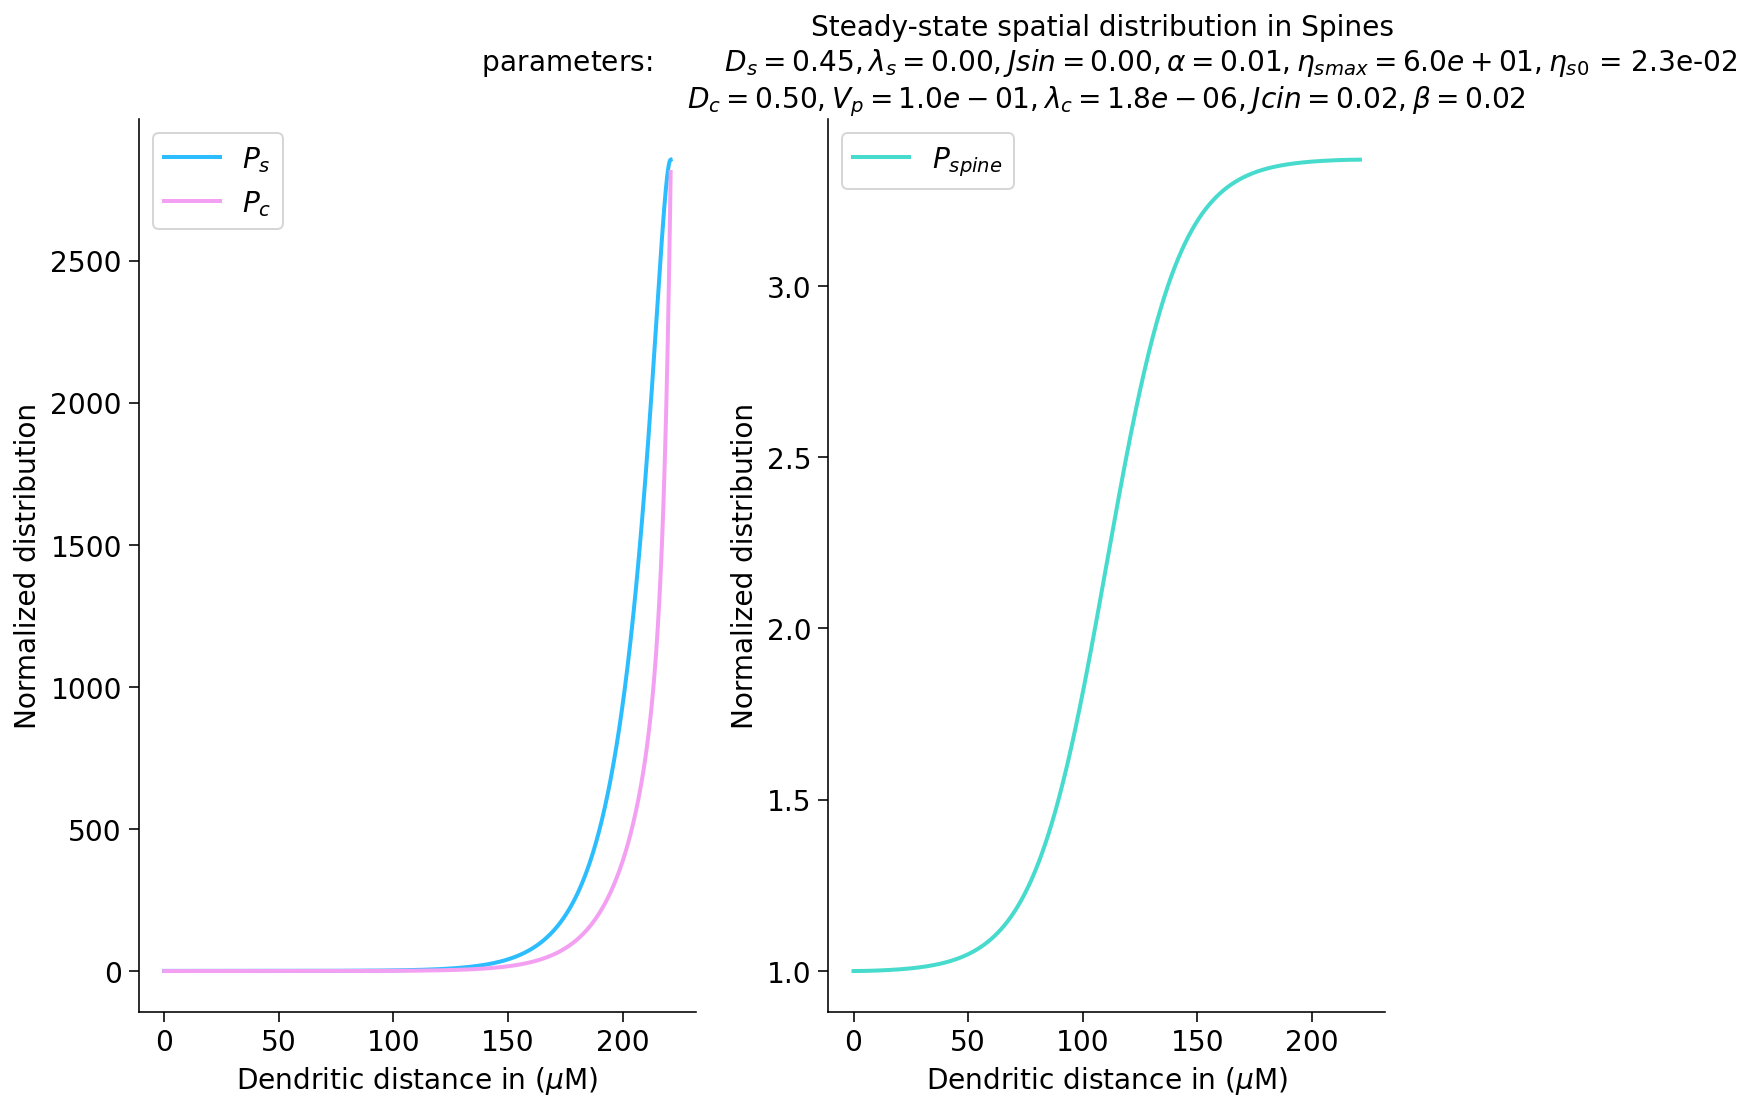

Plots not saved


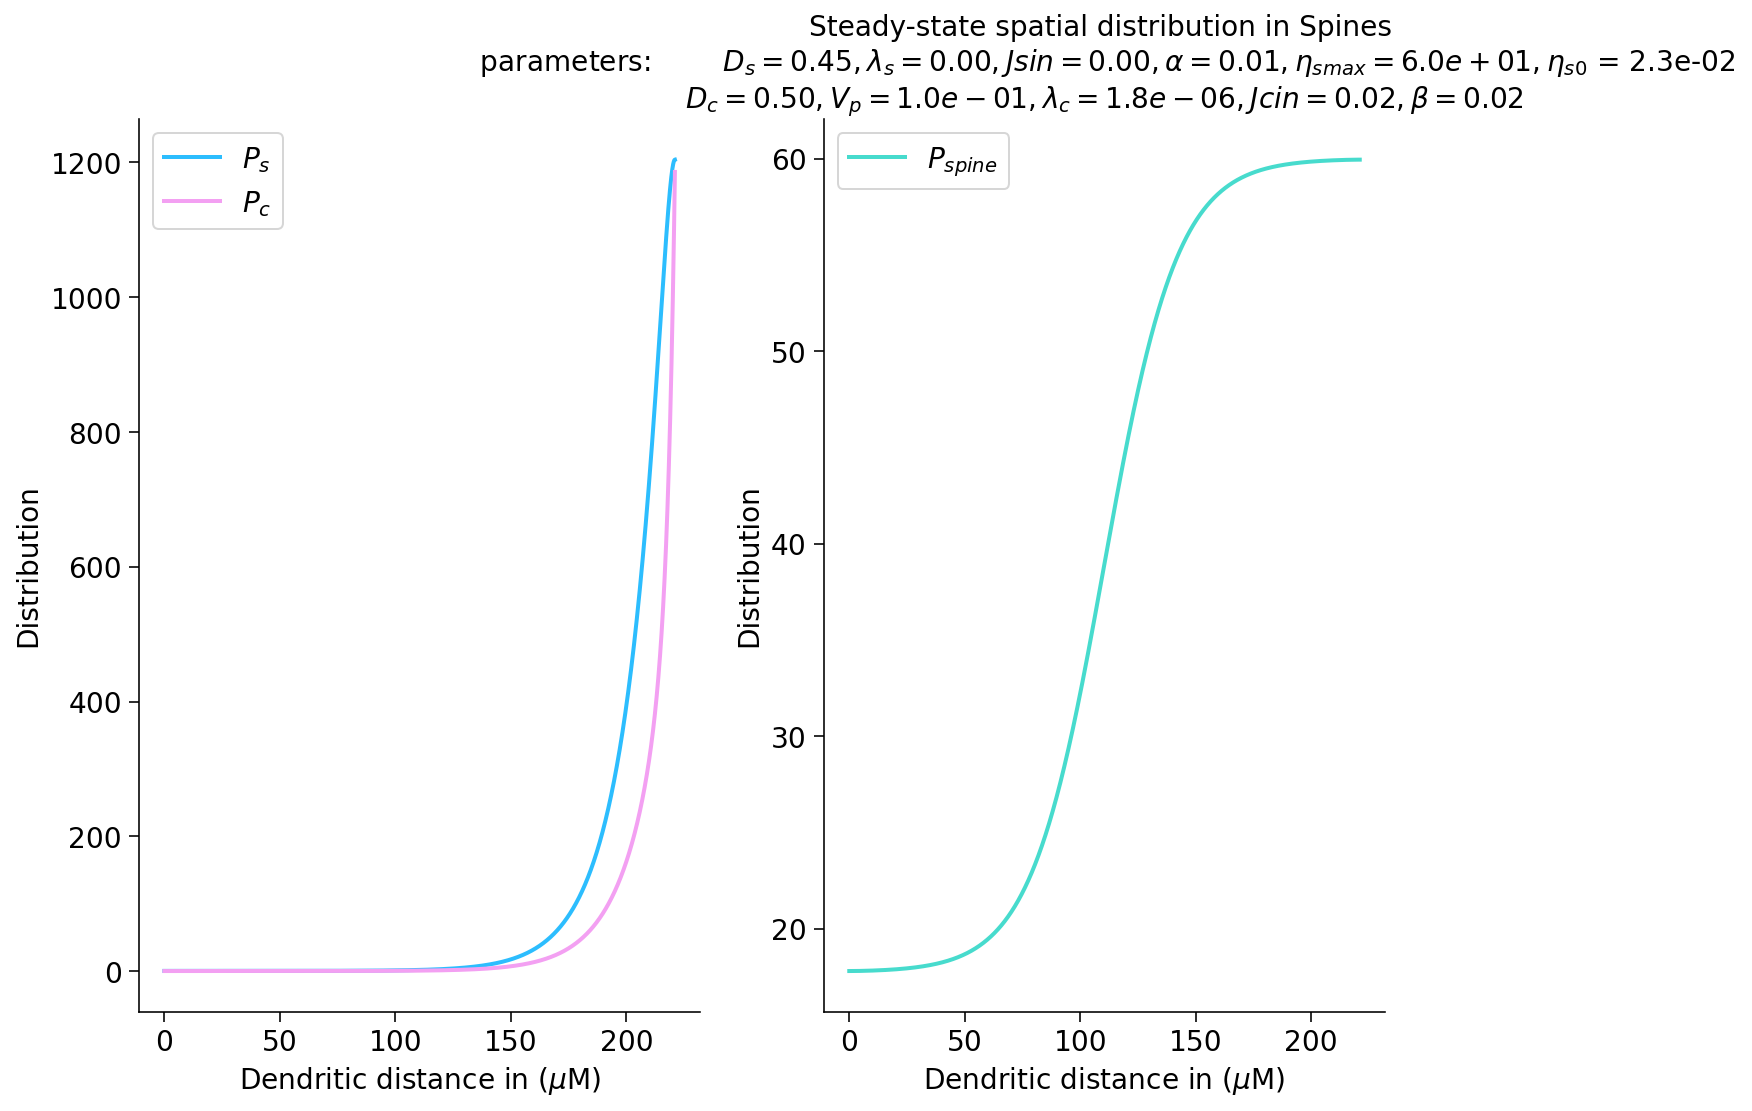

 v_p =0.01000 	|| Jin =  0 	|| alpha =0.01 	|| beta =0.02 	|| eta_s0 = 2.33e-02 
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.23e-10       1.97e-10         19386            0       
Solved in 1 iterations, number of nodes 19386. 
Maximum relative residual: 2.23e-10 
Maximum boundary residual: 1.97e-10
ratio of ps/pc =  1.9999935076615296 
 beta/alpha = 2.0
[45.58238447 45.58238913 45.58240311 45.58242638 45.58245891 45.58250068
 45.58255167 45.58261184 45.58268118 45.58275966 45.58284725 45.58294394
 45.58304969 45.58316449 45.5832883  45.58342111 45.58356288 45.5837136
 45.58387325 45.58404179] 
 [21.17435489 21.17870014 21.18303801 21.18736853 21.1916917  21.19600755
 21.2003161  21.20461737 21.20891138 21.21319816 21.21747772 21.22175008
 21.22601526 21.23027329 21.23452419 21.23876796 21.24300464 21.24723425
 21.2514568  21.25567231]
Plots not saved


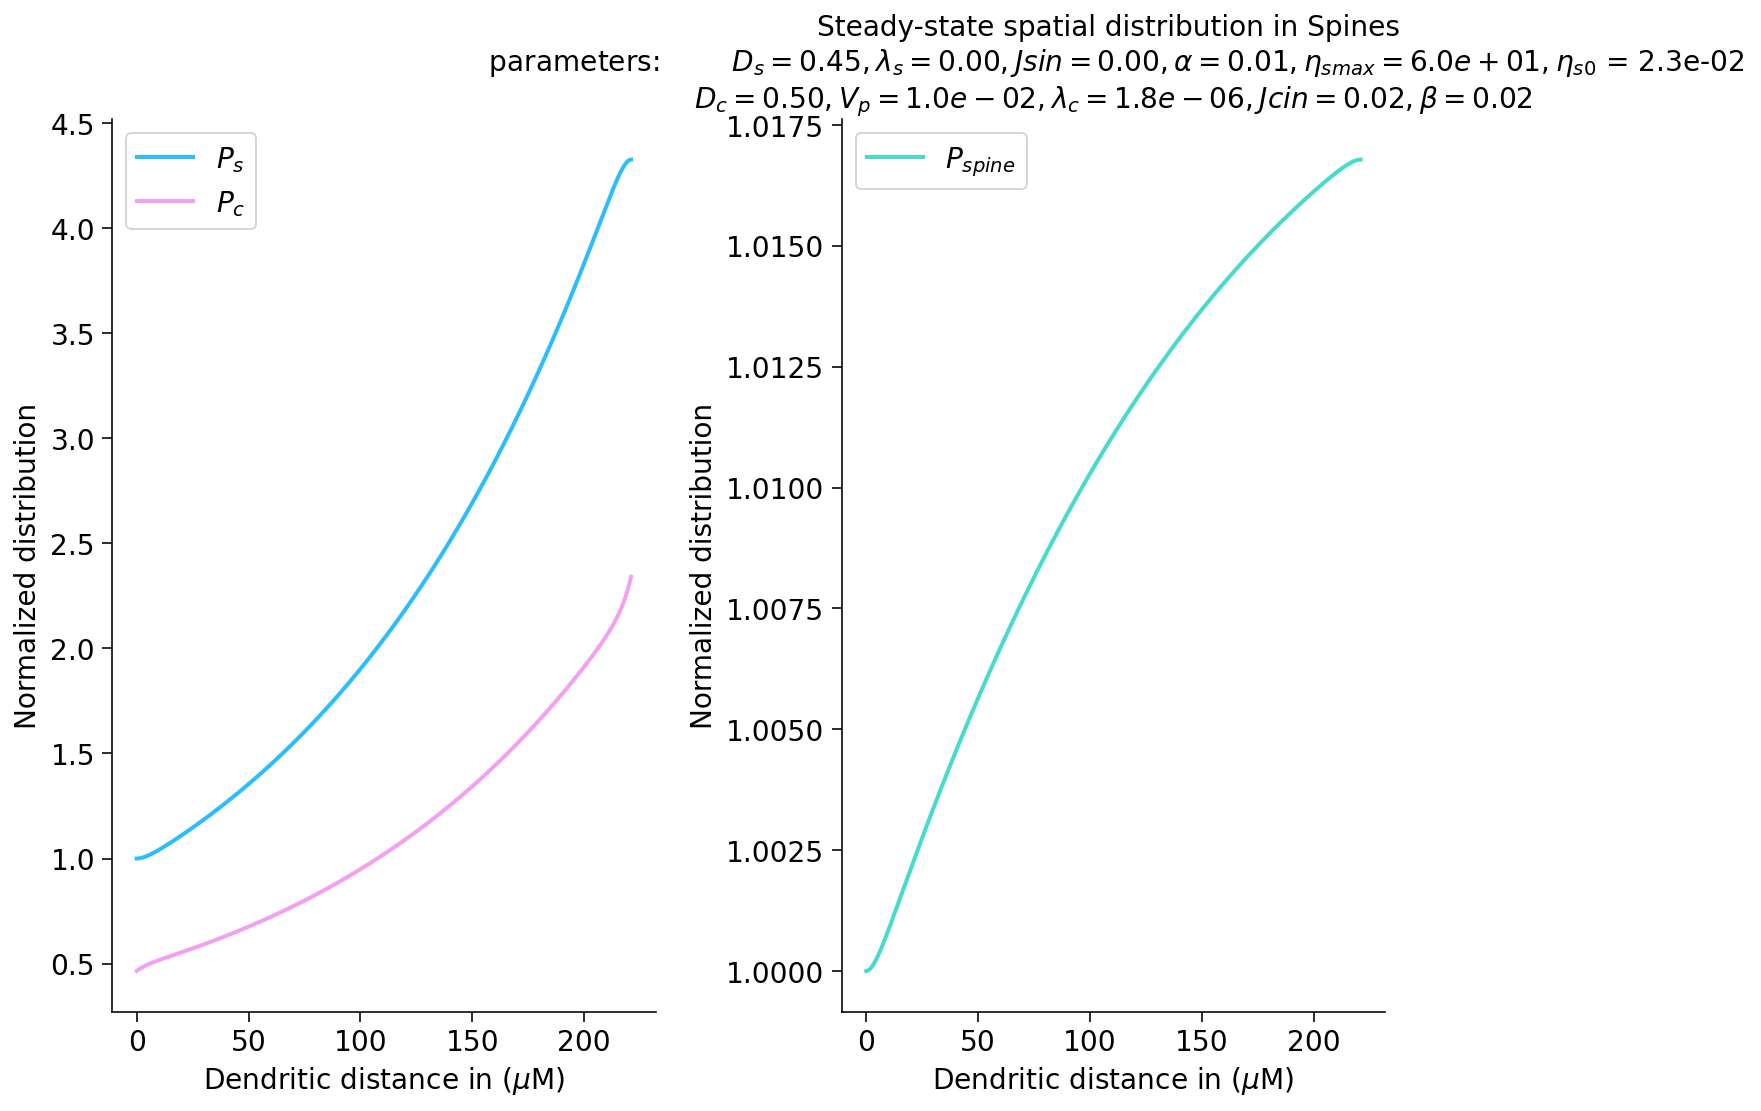

Plots not saved


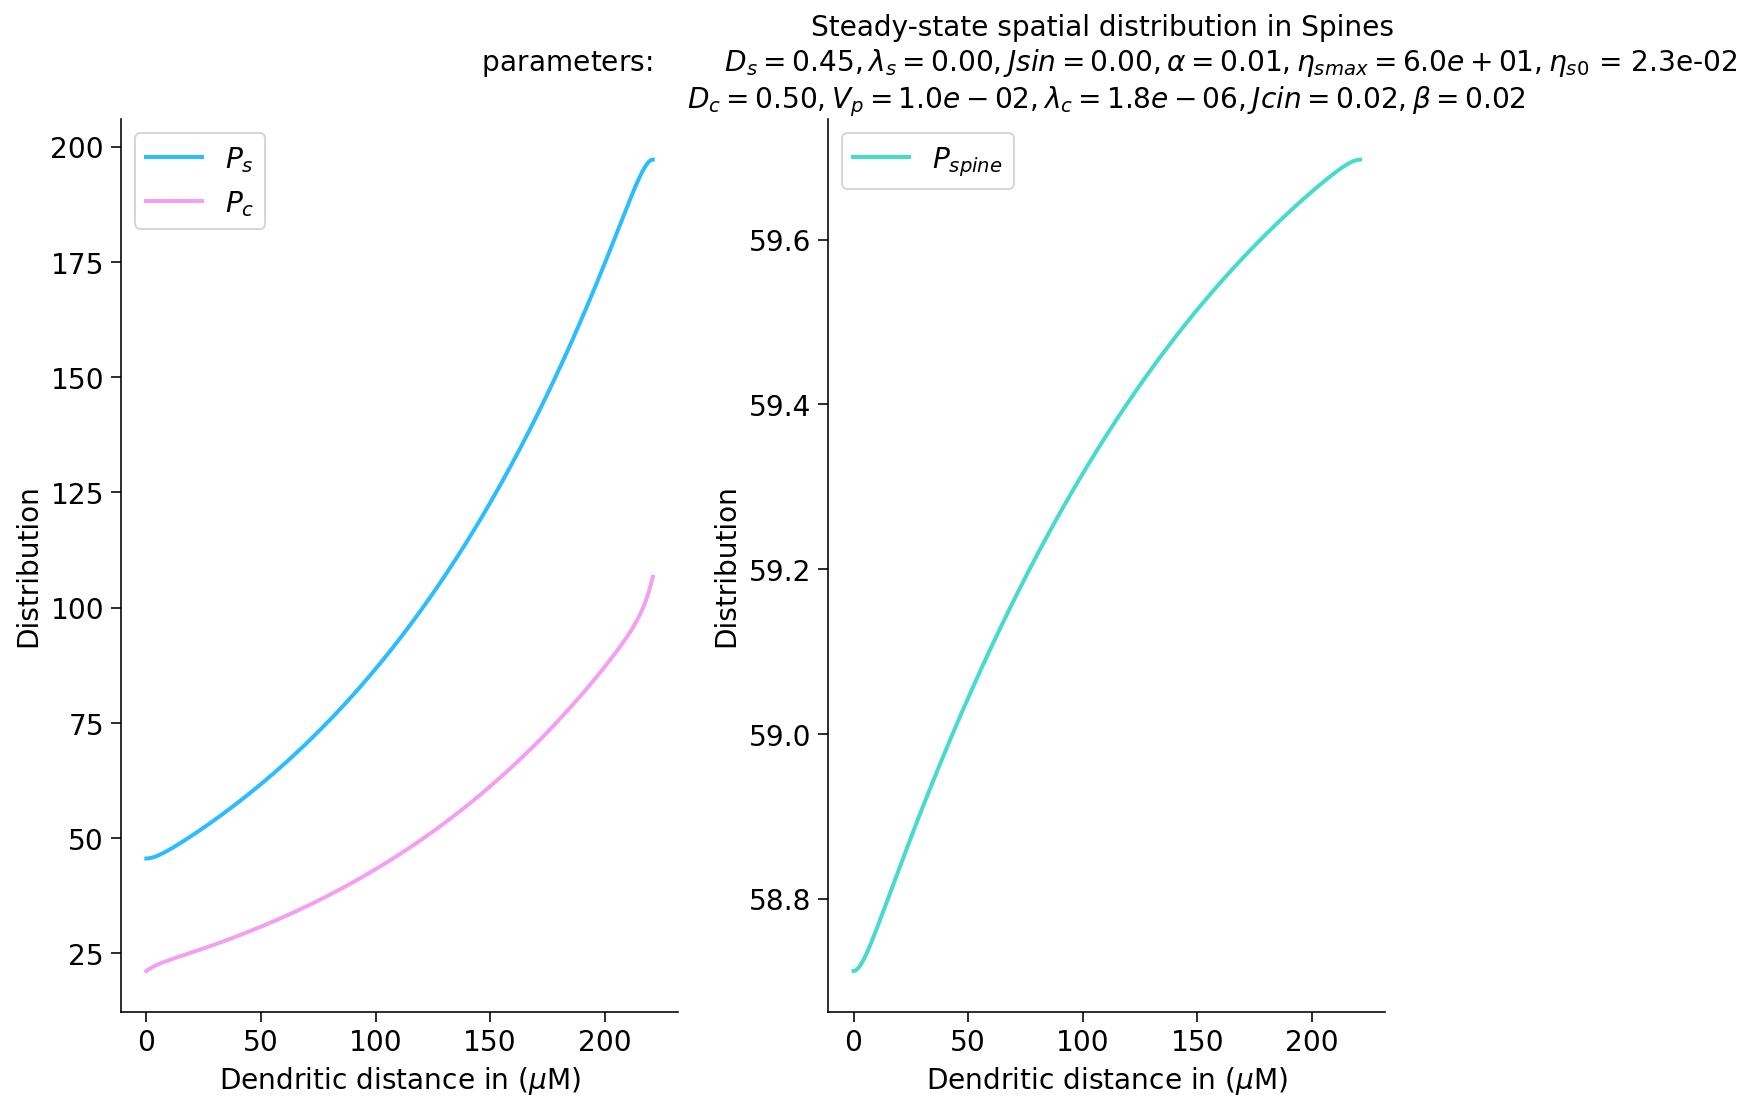

 v_p =0.00100 	|| Jin =  0 	|| alpha =0.01 	|| beta =0.02 	|| eta_s0 = 2.33e-02 
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.41e-11       3.34e-09         19386            0       
Solved in 1 iterations, number of nodes 19386. 
Maximum relative residual: 1.41e-11 
Maximum boundary residual: 3.34e-09
ratio of ps/pc =  1.9999997859796912 
 beta/alpha = 2.0
[97.49305343 97.49305407 97.49305602 97.49305925 97.49306377 97.49306958
 97.49307666 97.49308503 97.49309466 97.49310557 97.49311774 97.49313117
 97.49314586 97.49316181 97.49317901 97.49319746 97.49321715 97.49323809
 97.49326026 97.49328367] 
 [48.5217634  48.52239033 48.52301614 48.52364082 48.52426437 48.52488681
 48.52550814 48.52612835 48.52674746 48.52736546 48.52798236 48.52859815
 48.52921286 48.52982647 48.53043899 48.53105042 48.53166078 48.53227005
 48.53287824 48.53348536]
Plots not saved


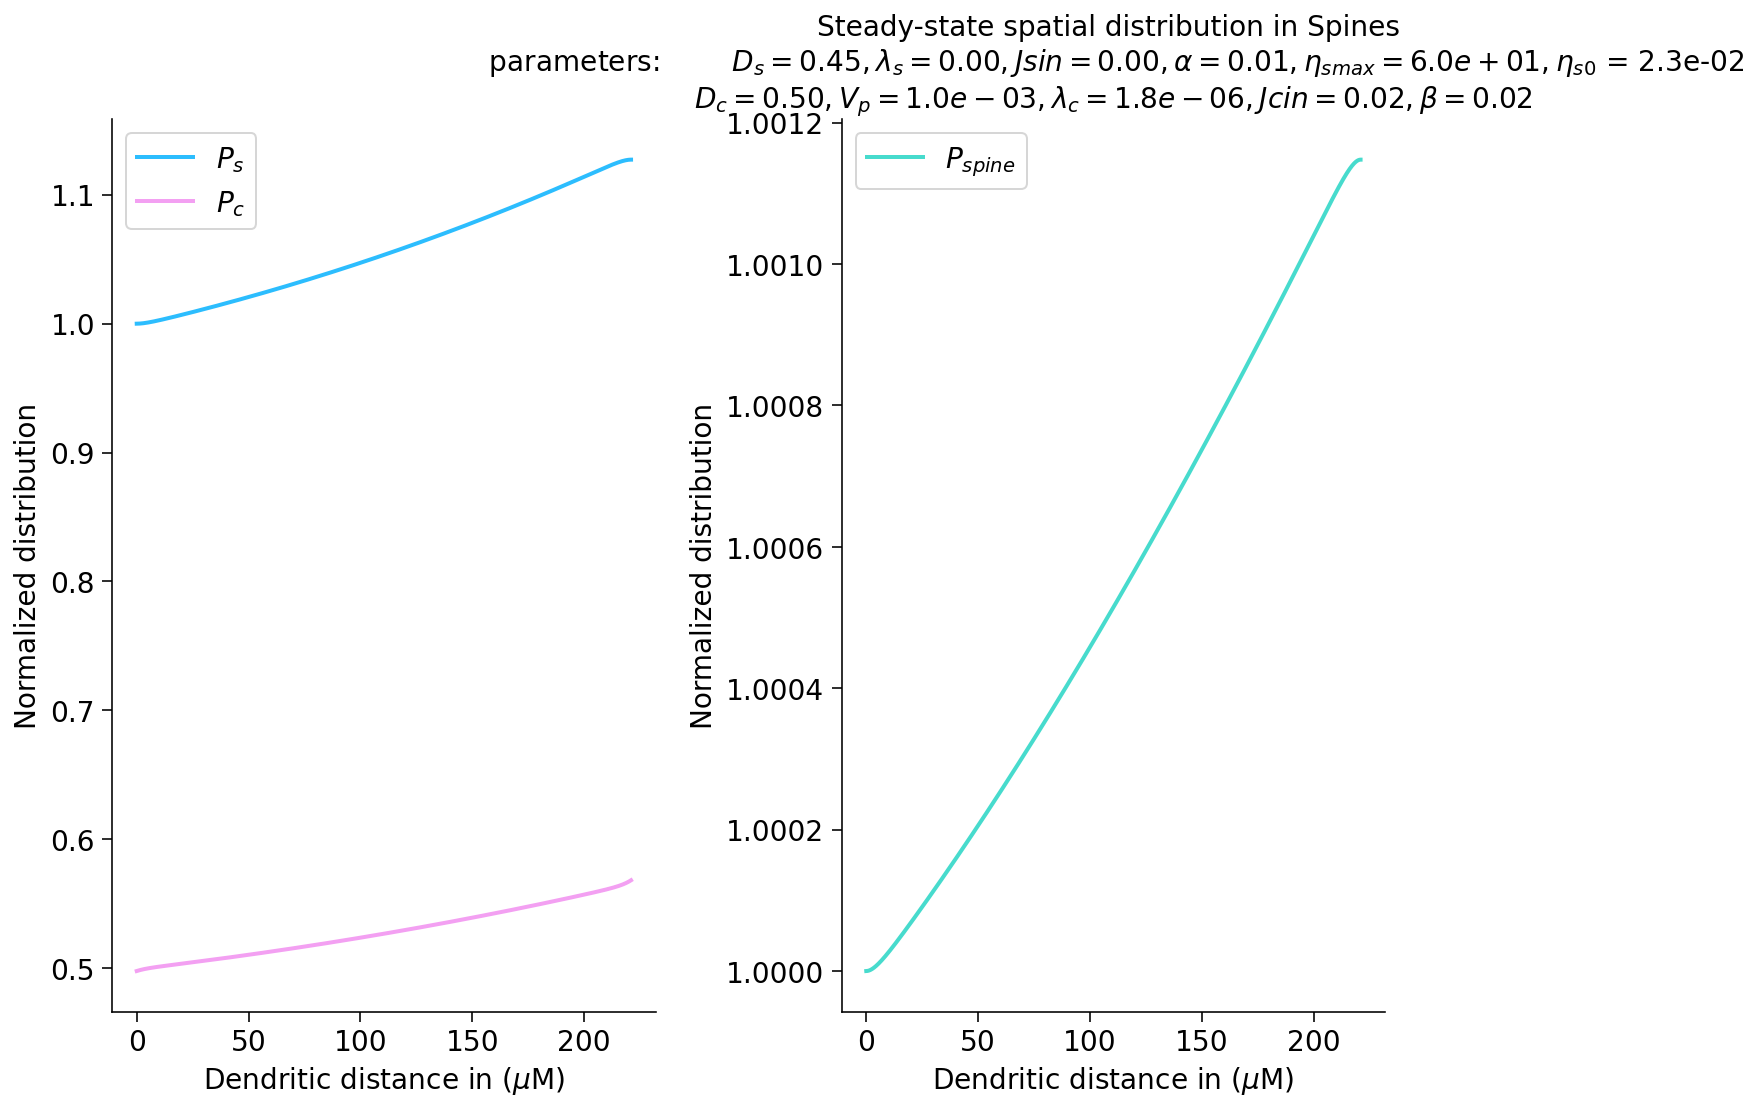

Plots not saved


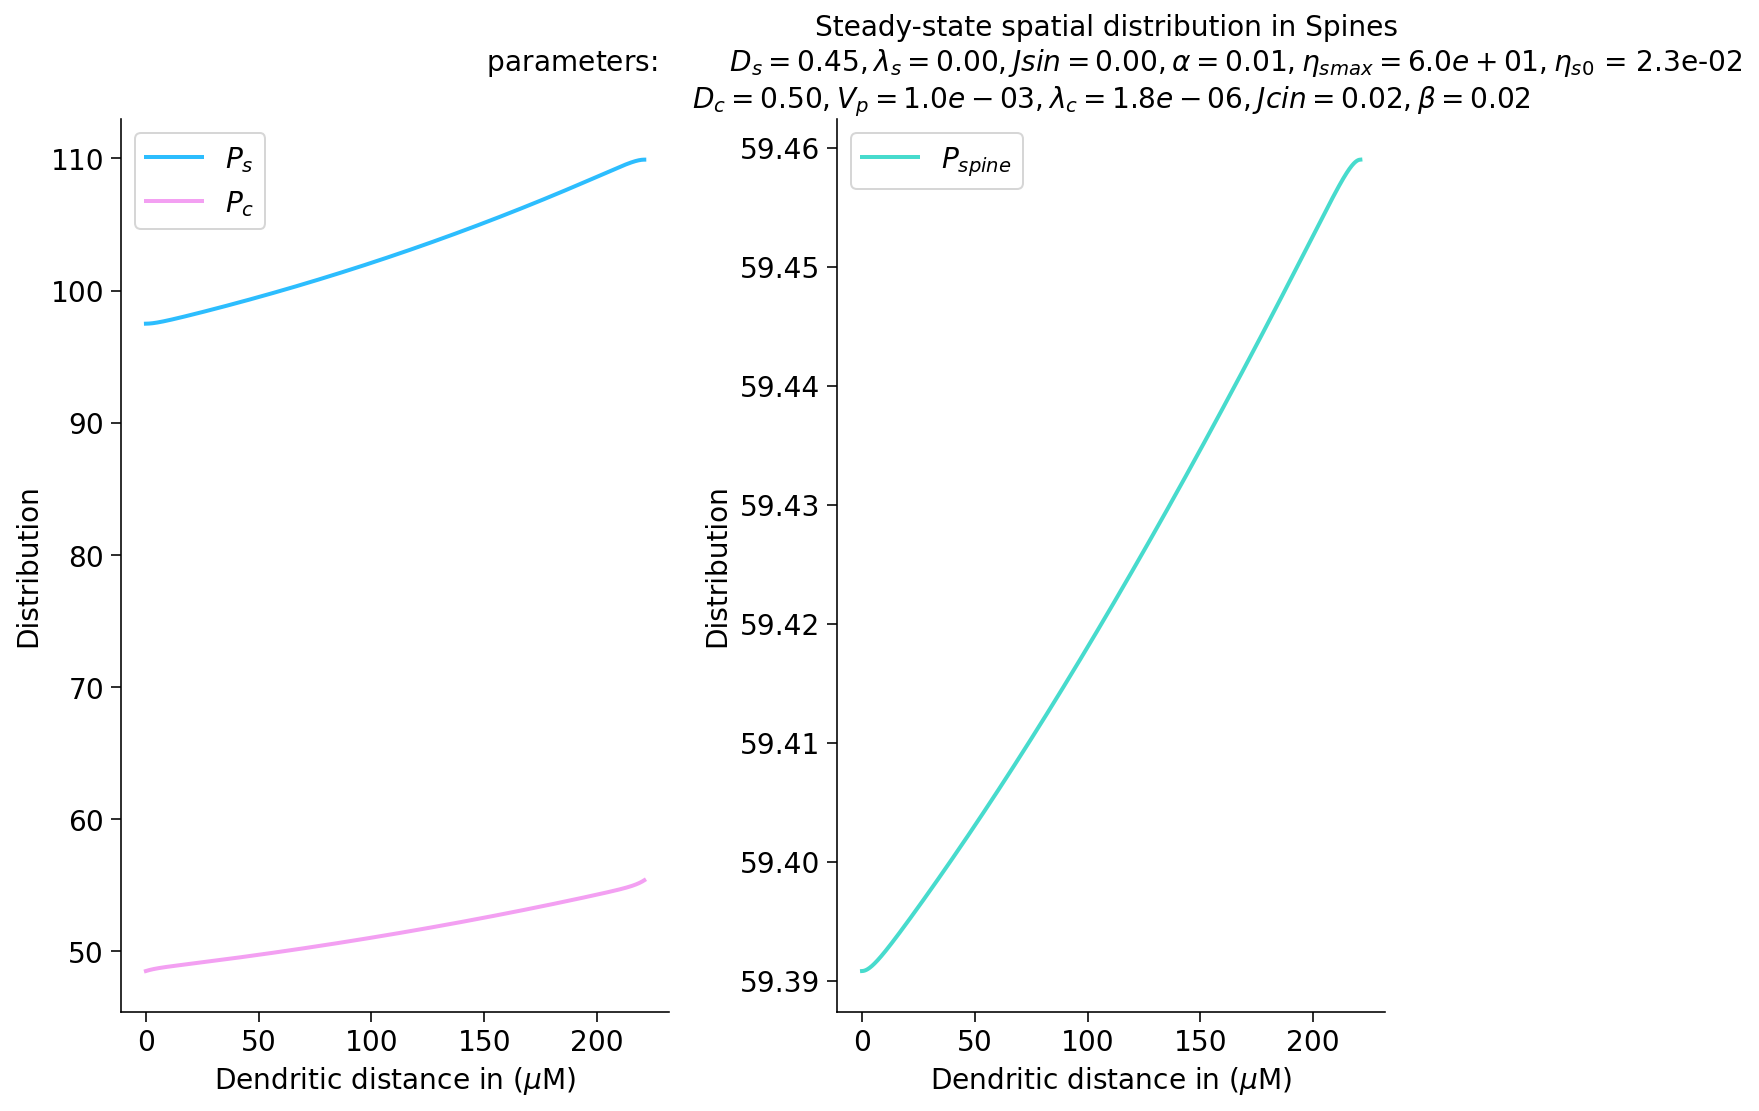

 v_p =0.00010 	|| Jin =  0 	|| alpha =0.01 	|| beta =0.02 	|| eta_s0 = 2.33e-02 
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.58e-12       3.29e-09         19386            0       
Solved in 1 iterations, number of nodes 19386. 
Maximum relative residual: 4.58e-12 
Maximum boundary residual: 3.29e-09
ratio of ps/pc =  1.9999998381769009 
 beta/alpha = 2.0
[104.35296367 104.35296331 104.35296224 104.35296047 104.35295799
 104.3529548  104.35295091 104.35294632 104.35294103 104.35293505
 104.35292837 104.352921   104.35291294 104.35290419 104.35289475
 104.35288463 104.35287383 104.35286234 104.35285018 104.35283734] 
 [52.29989581 52.29953658 52.29917802 52.29882013 52.29846289 52.29810631
 52.29775039 52.29739512 52.2970405  52.29668654 52.29633323 52.29598056
 52.29562854 52.29527716 52.29492642 52.29457633 52.29422687 52.29387805
 52.29352986 52.29318231]
Plots not saved


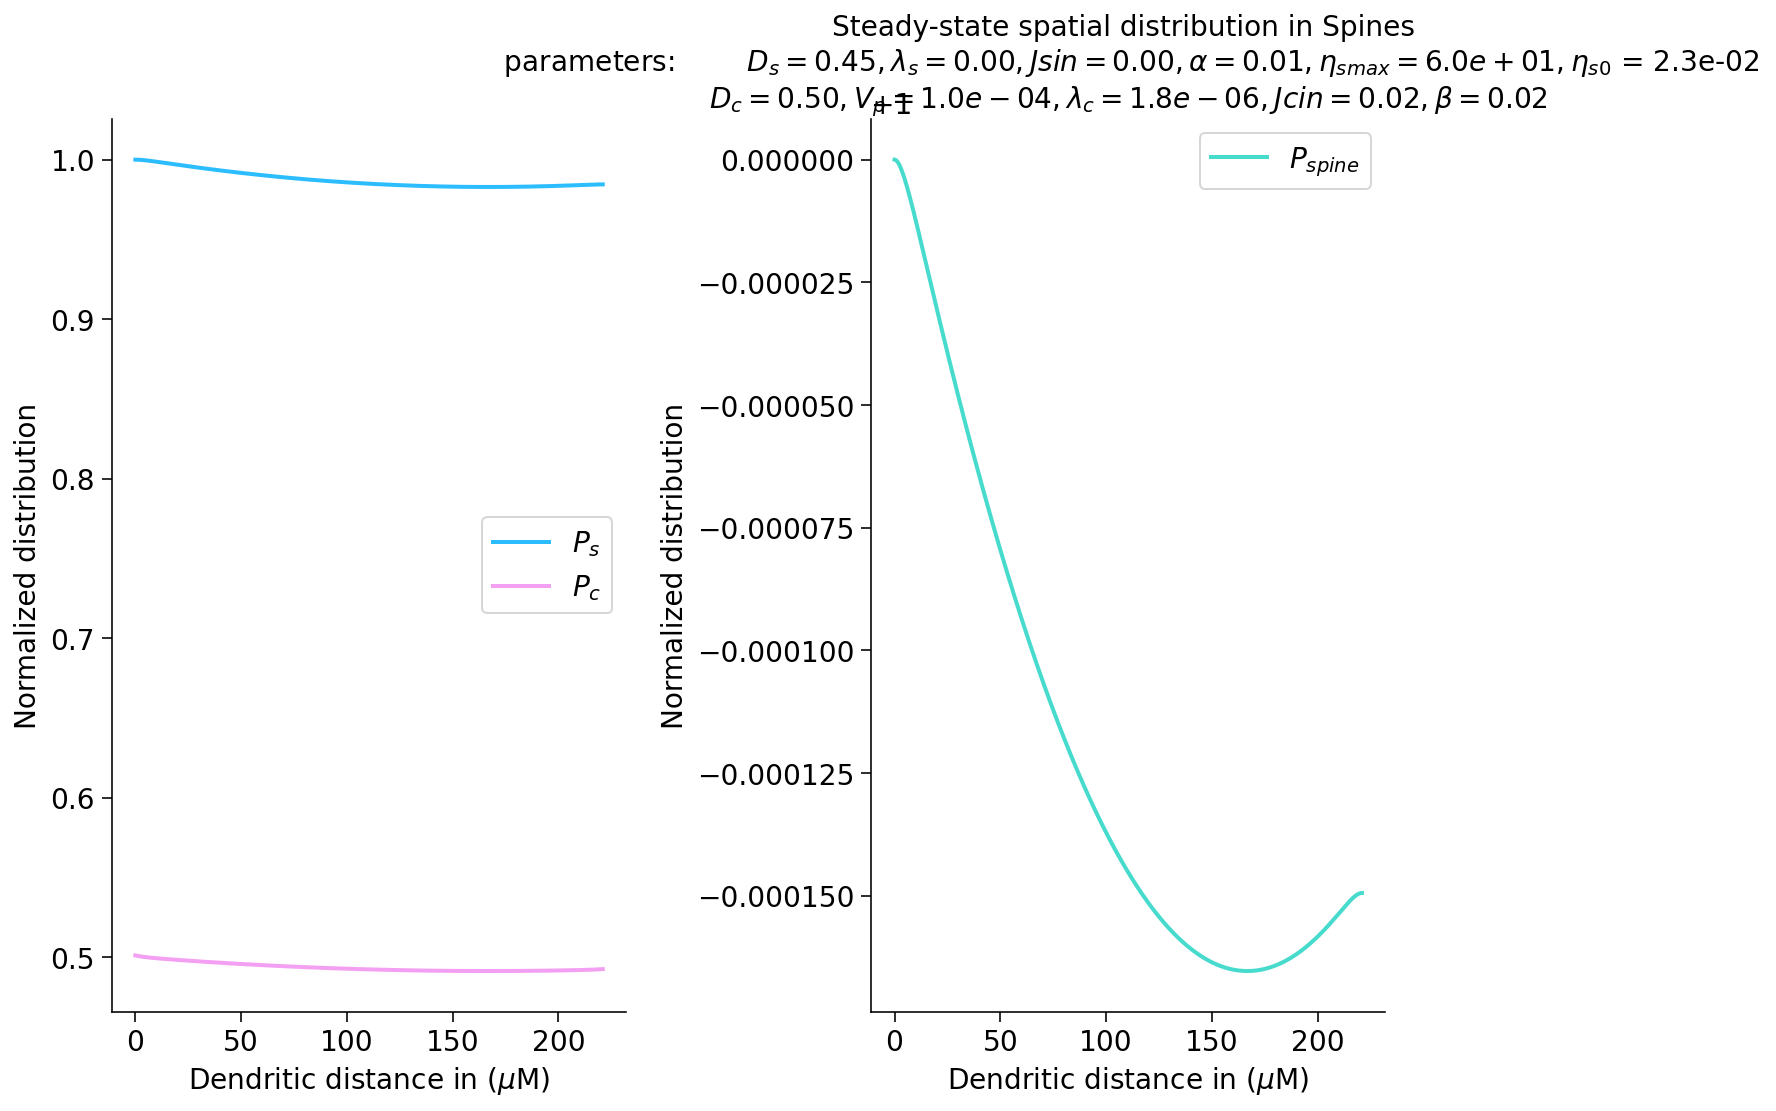

Plots not saved


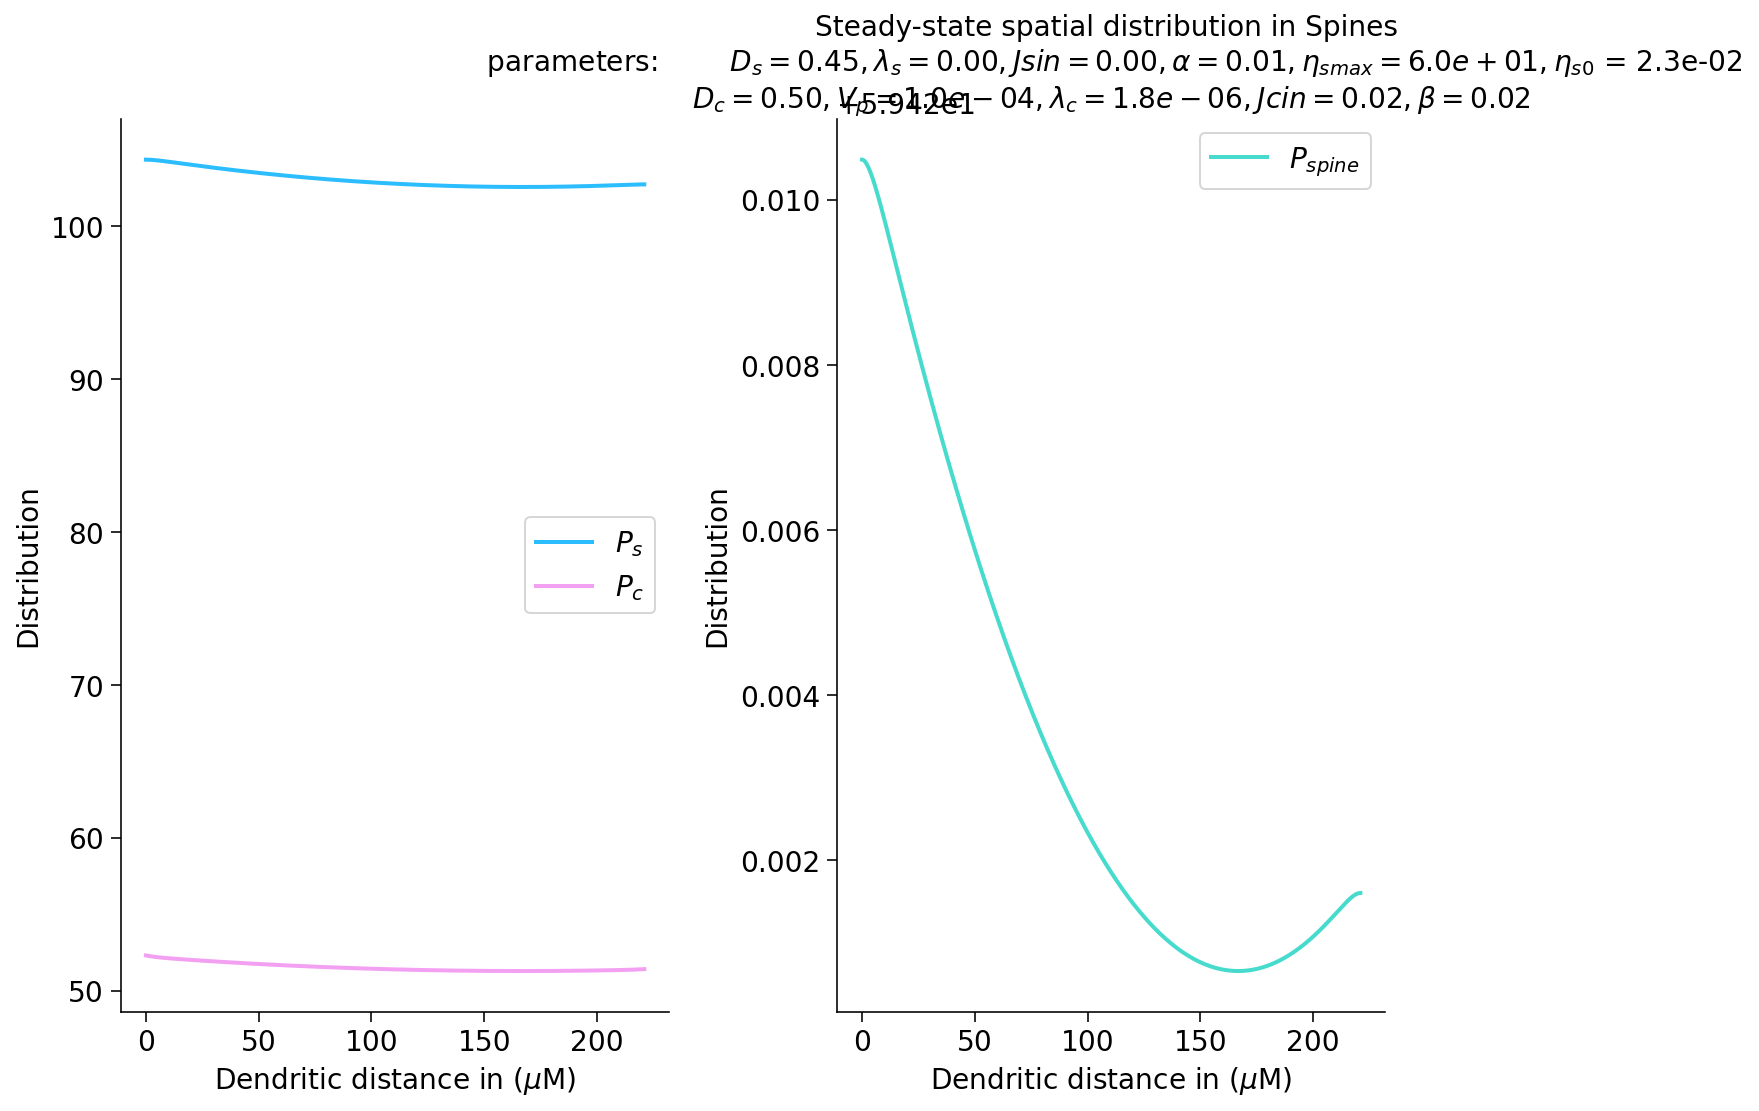

 v_p =0.00000 	|| Jin =  0 	|| alpha =0.01 	|| beta =0.02 	|| eta_s0 = 2.33e-02 
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.74e-12       6.29e-13         19386            0       
Solved in 1 iterations, number of nodes 19386. 
Maximum relative residual: 5.74e-12 
Maximum boundary residual: 6.29e-13
ratio of ps/pc =  1.9999998375052401 
 beta/alpha = 2.0
[105.13429128 105.1342908  105.13428937 105.134287   105.13428367
 105.1342794  105.1342742  105.13426805 105.13426097 105.13425295
 105.13424401 105.13423414 105.13422334 105.13421162 105.13419899
 105.13418543 105.13417097 105.13415559 105.1341393  105.13412211] 
 [52.73240096 52.7319226  52.73144513 52.73096853 52.73049281 52.73001796
 52.72954399 52.72907089 52.72859865 52.72812728 52.72765677 52.72718712
 52.72671832 52.72625038 52.7257833  52.72531706 52.72485168 52.72438713
 52.72392343 52.72346058]
Plots not saved


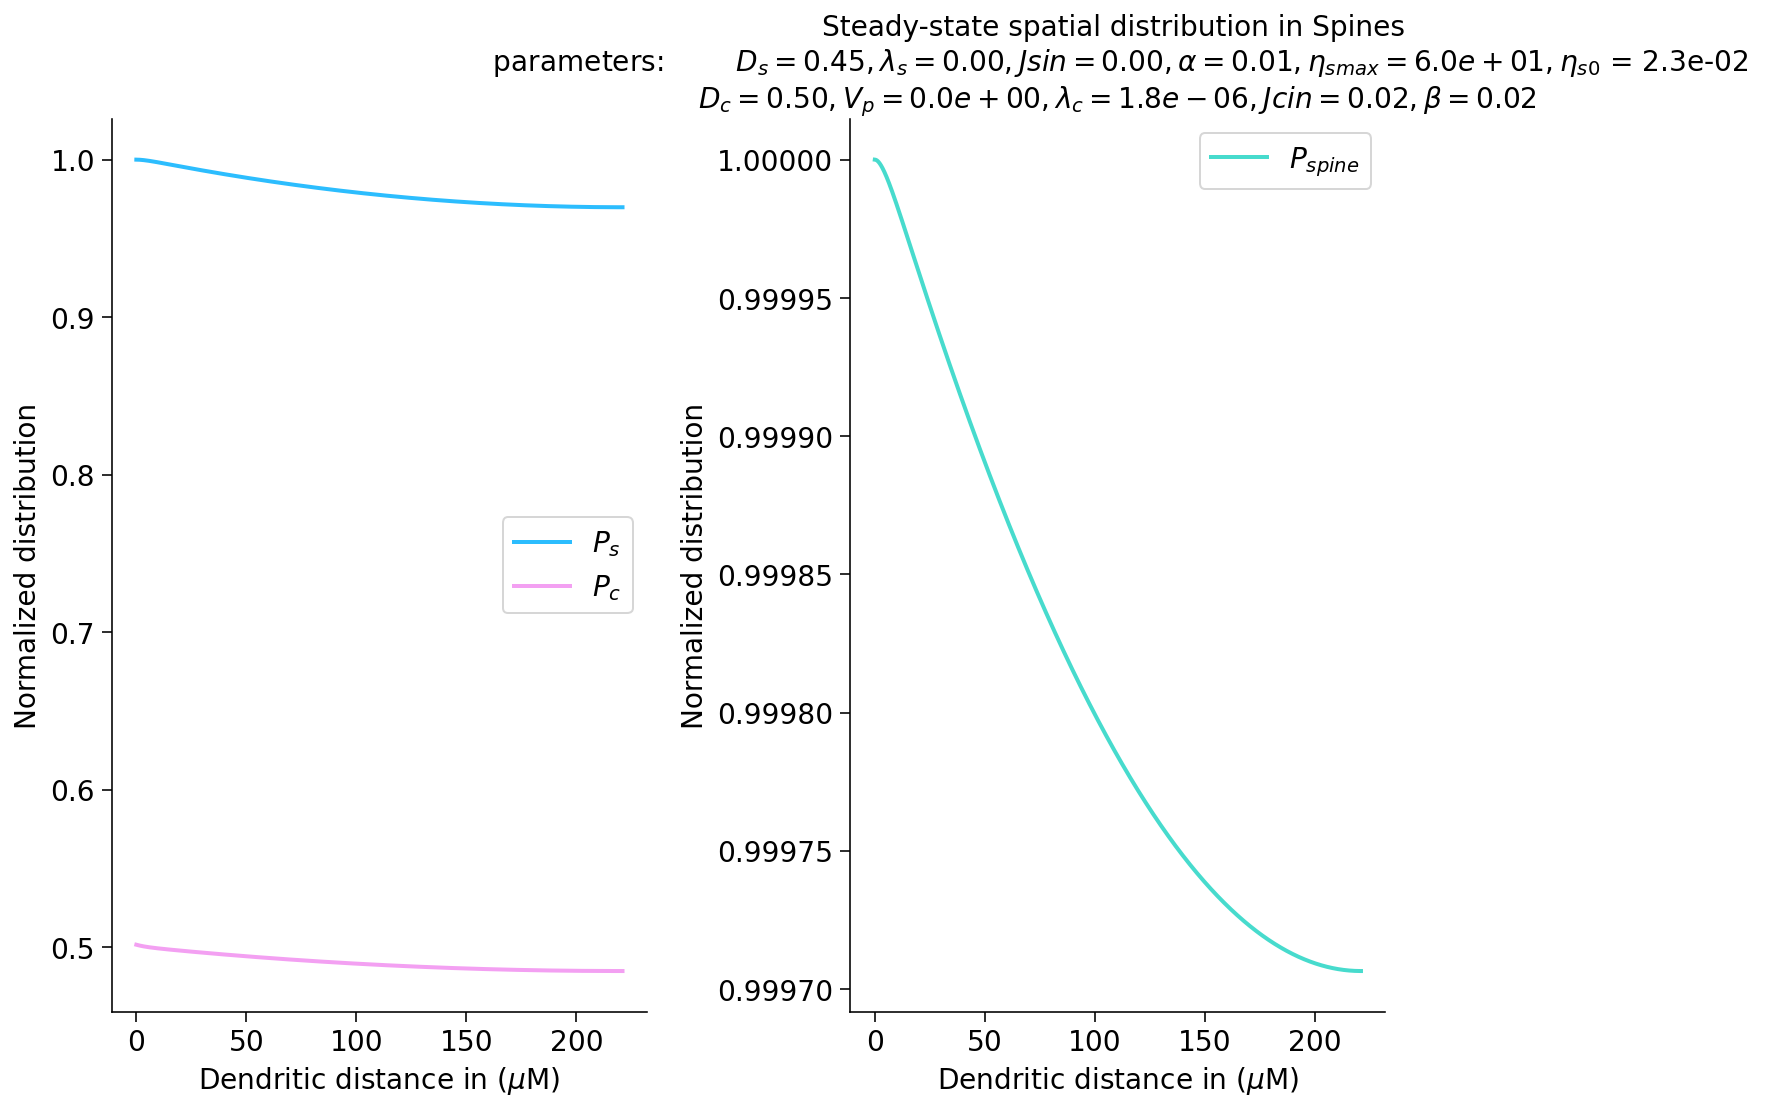

Plots not saved


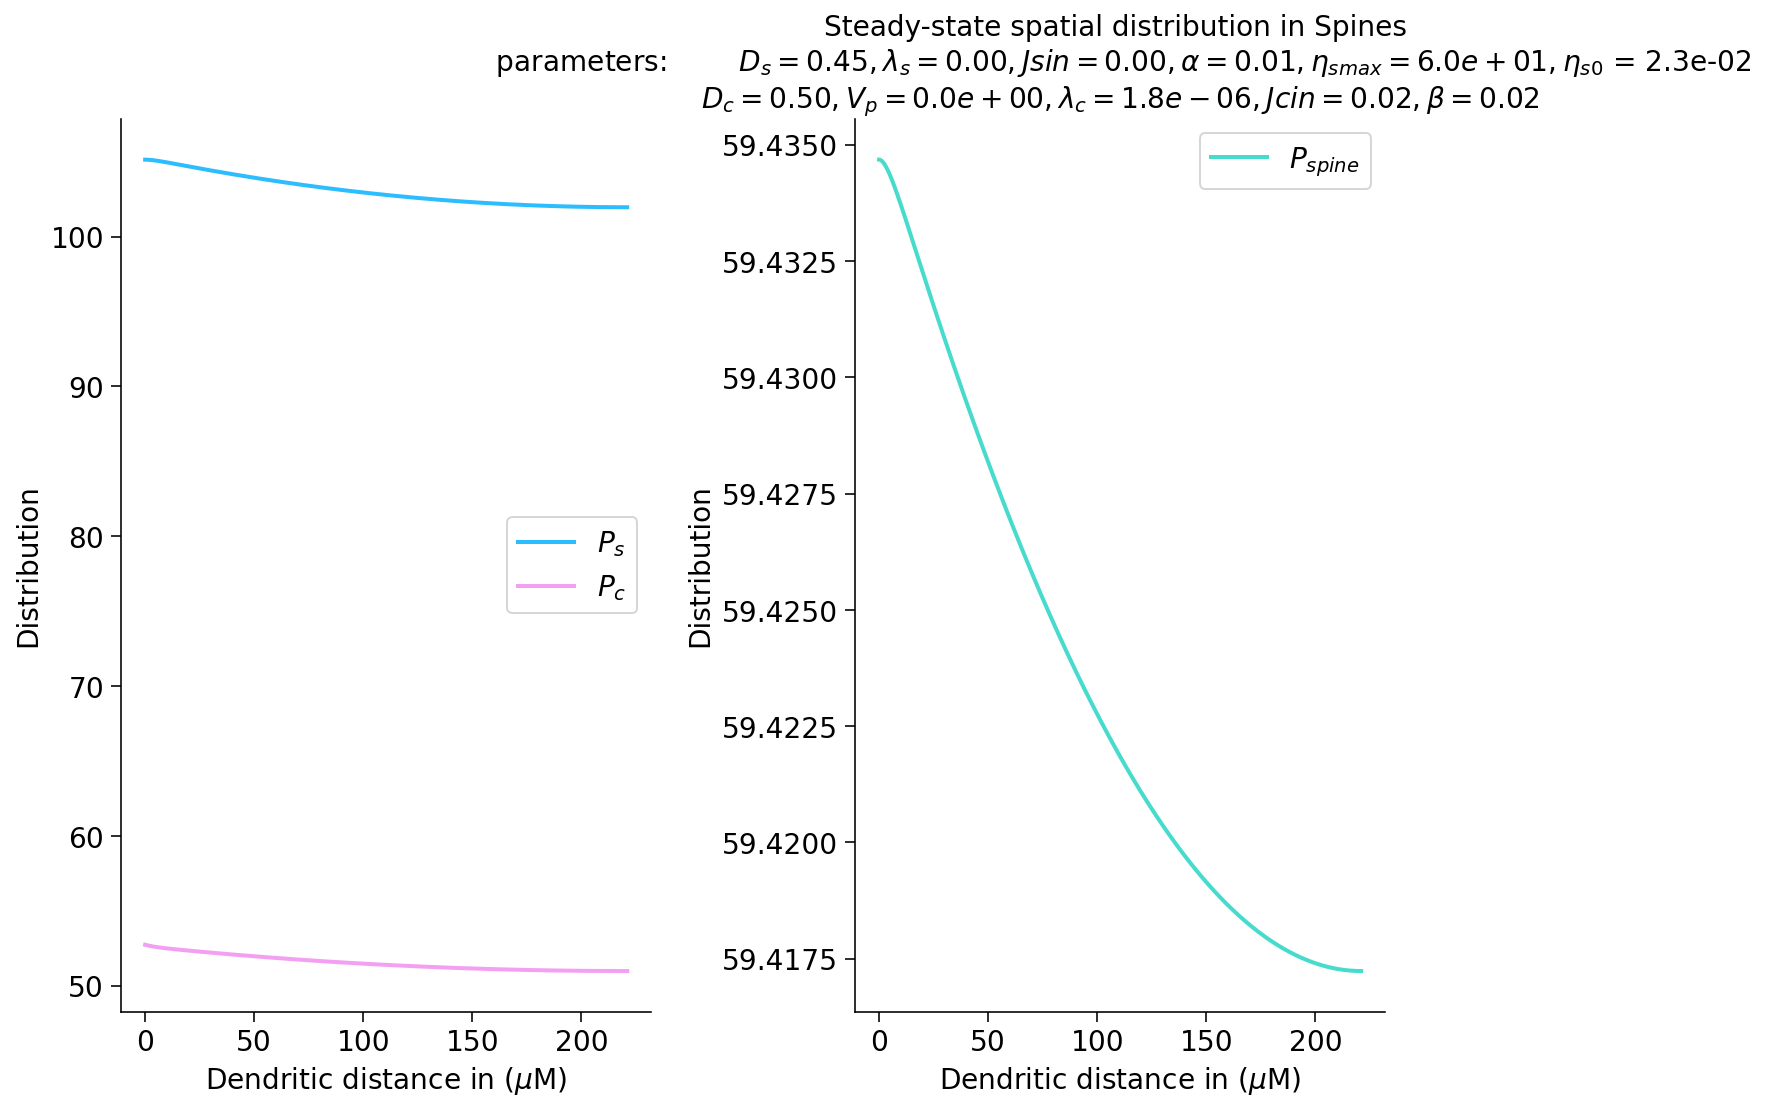

In [8]:
RunSim5(1e-1,0.021,alpha=0.01,beta = 0.02,eta_s0=1/43)
RunSim5(1e-2,0.021,alpha=0.01,beta = 0.02,eta_s0=1/43)
RunSim5(1e-3,0.021,alpha=0.01,beta = 0.02,eta_s0=1/43)
RunSim5(1e-4,0.021,alpha=0.01,beta = 0.02,eta_s0=1/43)
RunSim5(0,0.021,alpha=0.01,beta = 0.02,eta_s0=1/43)



## N. Two protein with two-rates for synaptic uptake

In [ ]:
class DendriteWithBidirectionalSpines():
    def __init__(self,D_s,D_c,V_p,half_life_surf,half_life_int,alpha,beta,Jsin,Jcin,eta_s,delta_s,eta_c):
        self.D_s = D_s   # in uM^2/s
        self.D_c = D_c   # in uM^2/s
        self.V_p = V_p    # in uM/s
        self.half_life_surf = half_life_surf # in days
        self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        self.half_life_int = half_life_int # in days
        self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        self.alpha = alpha;
        self.beta = beta;
        self.Jsin = Jsin;
        self.Jcin = Jcin;
        self.eta_s = eta_s;
        self.delta_s = delta_s
        self.eta_c = eta_c;
        
    def updateModelParams(self,D_s = None,D_c = None,V_p = None,half_life_surf = None,half_life_int = None\
                          ,alpha = None,beta = None,Jsin = None,Jcin = None,eta_s = None,eta_c = None):
        if D_s:
            self.D_s = D_s   # in uM^2/s
        if D_c:
            self.D_c = D_c   # in uM^2/s
        if V_p:
            self.V_p = V_p    # in uM/s
        if half_life_surf:
            self.half_life_surf = half_life_surf # in days
            self.Lamda_ps = np.log(2)/(self.half_life_surf*24*60*60);
        if half_life_int:
            self.half_life_int = half_life_int # in days
            self.Lamda_pc = np.log(2)/(self.half_life_int*24*60*60);
        if alpha:
            self.alpha = alpha;
        if beta:
            self.beta = beta;
        if Jsin:
            self.Jsin = Jsin;
        if Jcin:
            self.Jcin = Jcin;
        if eta_s:
            self.eta_s = eta_s;
        if delta_s:
            self.delta_s = delta_s;
        if eta_c:
            self.eta_c = eta_c;
    
    def fun(self,x,y):
        ps,dps,pc,dpc,psp= y
        return [dps,\
                ((self.alpha+self.Lamda_ps+self.eta_s)/self.D_s)*ps - (self.beta/self.D_s)*pc - self.delta_s*psp,\
                    dpc,\
                        ((self.beta+self.Lamda_pc+self.eta_c)/self.D_c)*pc + (self.V_p/self.D_c)*dpc - (self.alpha/self.D_c)*ps]
        
    def bc(self,ya,yb):
        return np.array([self.D_s*ya[1] + self.Jsin, self.D_s*yb[1], self.D_c*ya[3] - self.V_p*ya[2] + self.Jcin, self.D_c*yb[3]- self.V_p*yb[2], ya[4]-(self.eta_s/self.delta_s) *ya[0]])
    
    def solveModel(self):
        delta_x = 0.0114; #step size for the numerical simulation
        # sim_id="001";
        # print(len(x_line))
        # solving model
        # D_p * p'' - (V_p(x)*p)' - Lamda_p*p = 0
        x=np.arange(0,L,delta_x)
        print(x)
        # params=np.array([L]);
        y = np.zeros((5,x.size))
        soln = solve_bvp(self.fun, self.bc, x, y)
        print(len(soln))
        ps_dist = soln.sol(x)[0]
        pc_dist = soln.sol(x)[2]
        p_spine_dist = soln.sol(x)[2]
        # norm_ps_dist = ps_dist/ps_dist[0]
        # norm_pc_dist = pc_dist/ps_dist[0]
        # print(len(ps_dist))
        # plt.plot(x,ps_dist,label='P_s')
        # plt.plot(x,pc_dist,label='P_c')
        # plt.show()
#         self.IntegralBC(delta_x,ps_dist, pc_dist)
        return x,ps_dist,pc_dist,p_spine_dist



In [ ]:
sim_id = "001";
SP_model1 = DendriteWithBidirectionalSpines(0.45,0.05,0.1,float('inf'),4.35,0.1,0.2,0.0,0.1,0.06,1,0);
x,ps_dist,pc_dist,p_spine = SP_model1.solveModel()
title_string = "test title"
# title_string = (r"Steady-state spatial distribution"+" \n parameters:\
#    "+r" $D_s = %.2f, \lambda_s = %.2f,  \alpha = %.2f, \eta_s$ = %.1e "+" \n"+ \
#     r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, \beta = %.2f$") \
#     %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.alpha,SP_model1.eta_s,\
#       SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.beta);
lab_ps =  r'$P_s$'
lab_pc =  r'$P_c$'
x_label = r'Dendritic distance in ($\mu$M)';
y_label= r'distribution of $P_s$ and $P_c$';
folder= "Figures/TwoProtein/WithUptake/";
file_name = folder+"TwoProtein_SingleSim_{0}".format(sim_id);
# pwa = PlottingWidgetAMPA()
# pwa.CreateFolderRecursive(folder)
PlotSingleSimTwoProtein(x, ps_dist,pc_dist, lab_ps,lab_pc, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)
# title_string = (r"Steady-state spatial distribution in spines"+" \n parameters:\
#    "+r" $D_s = %.2f, \lambda_s = %.2f,  \alpha = %.2f, \eta_s$ = %.1e "+" \n"+ \
#     r"$D_c = {%.2f}, V_p = {%.1e}, \lambda_c = {%.1e}, \beta = %.2f$") \
#     %( SP_model1.D_s, SP_model1.Lamda_ps,SP_model1.alpha,SP_model1.eta_s,\
#       SP_model1.D_c,SP_model1.V_p, SP_model1.Lamda_pc,SP_model1.beta);
lab_p_spine =  r'$p_{spine}$'
x_label = r'Dendritic distance in ($\mu$M)';
y_label= r'distribution in spine';
file_name = folder+"Spine_SingleSim_TwoProtein_dist_{0}".format(sim_id);
# p_spine = SP_model1.eta_s*ps_dist -;
PlotSingleSimSingleProtein(x,np.zeros((np.shape(x))),p_spine,lab_ps,lab_p_spine, x_label, y_label, title_string, file_name,fsize=16,save_it = 0)